## Project 1: Wildfire Prediction

In [1]:
import datetime as dt
from pathlib import Path
import math
import os
import sqlite3
import json
import geopandas as gpd
import pygeos
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from functools import partial


from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Data Collection

#### 1a.	Load the dataset 1: All California Fire Dataset - https://gis.data.ca.gov/

In [2]:
ca_fires_df = gpd.read_file("Data/California_Fire_Perimeters_(all).geojson")
ca_fires_df.head(2)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,SHAPE_Length,SHAPE_Area,geometry
0,21440,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,,110.0,109.60250,1.0,1.0,None,0.035733,0.000046,"MULTIPOLYGON (((-121.34842 38.88999, -121.3483..."
1,21441,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,,670.0,685.58502,1.0,1.0,None,0.101178,0.000288,"MULTIPOLYGON (((-121.35276 38.82039, -121.3526..."


In [3]:
ca_fires_df.shape

(21318, 19)

In [4]:
ca_fires_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### 1a.	Load the dataset 1: Supplementary Data for Fire Incident Location - https://data-nifc.opendata.arcgis.com/

In [5]:
fire_location = gpd.read_file("Data/WFIGS_-_Wildland_Fire_Locations_Full_History.geojson")
print(fire_location.shape)
fire_location.head(2)

(208013, 95)


,OBJECTID,ABCDMisc,ADSPermissionState,CalculatedAcres,ContainmentDateTime,ControlDateTime,DailyAcres,DiscoveryAcres,DispatchCenterID,EstimatedCostToDate,...,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,Source,GlobalID,IsCpxChild,CpxName,CpxID,geometry
0,1,None,CERTIFIED,50.64,2020-08-06T23:13:07+00:00,2020-08-06T23:13:25+00:00,50.6,20.0,MTMCC,NaN,...,None,None,2020-08-06T19:50:29.023001+00:00,2020-08-12T20:46:01.557000+00:00,IRWIN,e5436898-ed0d-4cb1-90c0-d61915fe1f29,NaN,None,None,POINT (-104.45751 45.78504)
1,2,None,DEFAULT,NaN,None,None,NaN,0.1,CALACC,NaN,...,None,None,2020-02-28T20:52:36.362999+00:00,2020-02-28T20:52:36.362999+00:00,IRWIN,0e79b7fd-2882-43cf-8cfa-911bd1c8f77a,NaN,None,None,POINT (-118.18071 33.80898)


#### 1a.	Load the dataset 1: Supplementary California Fire Dataset - https://www.fire.ca.gov/

In [6]:
fires_df = pd.read_csv('Data/California_Fire_Incidents.csv')
print(fires_df.shape)

(1636, 40)


#### USA Shape File https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [7]:
USA = gpd.read_file("Data/County/cb_2018_us_county_500k.shp")
USA.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


#### 1b. Load the dataset 2: NASA Active Fire Data - https://earthdata.nasa.gov/

In [8]:
current_dir = Path(os.getcwd()).absolute()

In [9]:
old_nasa_df = pd.read_csv('Data/fire_archive_M6_156000.csv') # archive data 
new_nasa_df = pd.read_csv('Data/fire_nrt_M6_156000.csv') # new data 

nasa_df = pd.concat([old_nasa_df, new_nasa_df]) #concatenate old and new data
print(nasa_df.shape)
nasa_df.tail(4)

(1248606, 15)


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
66330,36.293,-118.664,329.6,1.1,1.0,2020-09-27,1855,Terra,MODIS,66,6.0NRT,297.3,24.9,D,NaN
66331,40.043,-123.080,337.5,1.2,1.1,2020-09-27,1855,Terra,MODIS,88,6.0NRT,302.2,40.3,D,NaN
66332,45.726,-118.308,305.5,1.0,1.0,2020-09-27,1855,Terra,MODIS,30,6.0NRT,293.1,6.5,D,NaN
66333,37.262,-119.443,319.4,1.0,1.0,2020-09-27,1855,Terra,MODIS,65,6.0NRT,300.6,9.9,D,NaN


#### 1c. Load the dataset 3: US Drought Data - https://power.larc.nasa.gov/

In [10]:
drought_soil = pd.read_csv('Data/Drought_Soil.csv')

#### 1d. Daily weather summary data https://www.noaa.gov/

In [227]:
# import necessary libraries
import glob
  
# use glob to get all the csv files 
# in the folder
current_dir = Path(os.getcwd()).absolute()
data_dir = current_dir.joinpath('Data')
weather_dir = data_dir.joinpath('weather')
csv_files = glob.glob(os.path.join(weather_dir, "*.csv"))


# loop over the list of csv files
df_list = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)
    df_list.append(df)

In [228]:
ca_daily_df = []
for i in df_list:
    df = pd.DataFrame(i)
    df = df.dropna()
    ca_daily_df.append(df)
ca_daily_df = pd.concat(ca_daily_df)

### Data Preliminary Analysis

In [13]:
# check for missing value
def percentMissing(df):
    
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    
    # % of missing data
    for col in df.columns:
        # create missing indicator for features with missing data
        missing = df[col].isnull()
        pct_missing = np.mean(missing)*100
        #if pct_missing >60:
        print('{} - {}%'.format(col, round(pct_missing)))
        num_missing = np.sum(missing)

In [14]:
# Checking data type
def Datatype(df):
    # shape and data types of the data
    print("There are {} rows and {} columns".format(df.shape[0], df.shape[1]))
    print(df.dtypes)

    # select numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    print(numeric_cols)

    # select non numeric columns
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    non_numeric_cols = df_non_numeric.columns.values
    print(non_numeric_cols)

### 1a. Data Exploration: All California Fire Dataset

#### All Fire Incident Geopoint data to map fire with right date and time for the first discovery or reported fire incident

In [15]:
fire_location = fire_location[(fire_location['InitialLatitude']<= 42) & (fire_location ['InitialLatitude'] >= 32)]
fire_location = fire_location[(fire_location['InitialLongitude']<= -114) & (fire_location['InitialLongitude'] >= -126)]

In [16]:
fire_location = fire_location[['InitialLatitude','InitialLongitude','FireDiscoveryDateTime','ContainmentDateTime',
                               'ControlDateTime','FireOutDateTime','POOState','FireCause','GACC','IncidentName',
                               'LocalIncidentIdentifier','UniqueFireIdentifier','WFDSSDecisionStatus','geometry']]

In [17]:
import string
import re
def get_year(text):
    pattern = r'[^A-Za-z ]'
    if re.search("[^0-9]", text):
        year = text[0:4]
    else:
        None
    return year

In [18]:
fire_location['IncidentYear'] = fire_location['UniqueFireIdentifier'].apply(lambda x: get_year(x))

In [19]:
fire_location['IncidentYear'] = fire_location['IncidentYear'].astype(int)

In [20]:
fire_location = fire_location[(fire_location['IncidentYear'] >=2010) & (fire_location['POOState']=='US-CA')]
fire_location = fire_location[fire_location['IncidentYear'] <=2020]

In [21]:
fire_location = fire_location.drop(['ContainmentDateTime', 'ControlDateTime',
                                    'FireOutDateTime', 'WFDSSDecisionStatus'], axis = 1)

In [22]:
fire_location.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
fire_location['DiscoveryDate'] = fire_location['FireDiscoveryDateTime'].astype('datetime64[ns]')
fire_location['DiscoveryDate']= fire_location['DiscoveryDate'].dt.strftime('%Y-%m-%d')
fire_location['DiscoveryDate'] = fire_location['DiscoveryDate'].astype('datetime64[ns]')
fire_location['DiscoveryYear'] = fire_location['DiscoveryDate'].dt.year
fire_location['DiscoveryMonth'] = fire_location['DiscoveryDate'].dt.month
fire_location['DiscoveryDay'] = fire_location['DiscoveryDate'].dt.day

In [24]:
fire_location = fire_location[['UniqueFireIdentifier', 'IncidentYear', 'IncidentName', 'DiscoveryDate', 
                               'DiscoveryYear','DiscoveryMonth', 'DiscoveryDay', 'geometry']]

In [25]:
fire_location.head(2)

,UniqueFireIdentifier,IncidentYear,IncidentName,DiscoveryDate,DiscoveryYear,DiscoveryMonth,DiscoveryDay,geometry
1,2020-CALAC-066100,2020,LAC-066100,2020-02-28,2020,2,28,POINT (-118.18071 33.80898)
9,2015-CAYNP-000028,2015,41,2015-06-09,2015,6,9,POINT (-119.69301 37.63881)


In [26]:
fire_location = fire_location.sort_values(['DiscoveryDate'], ascending=True)

In [27]:
percentMissing(fire_location)

UniqueFireIdentifier - 0%
IncidentYear - 0%
IncidentName - 0%
DiscoveryDate - 0%
DiscoveryYear - 0%
DiscoveryMonth - 0%
DiscoveryDay - 0%
geometry - 0%


Check for Correct year for fire incidents and delete duplicates based on coordinates and date

In [28]:
fire_location["Disc_minus_ID"] = fire_location["IncidentYear"] - fire_location["DiscoveryYear"]
fire_location[fire_location["Disc_minus_ID"]!=0]

,UniqueFireIdentifier,IncidentYear,IncidentName,DiscoveryDate,DiscoveryYear,DiscoveryMonth,DiscoveryDay,geometry,Disc_minus_ID
53158,2016-CACNF-002667,2016,MUTUAL AID DE LUZ,2015-08-09,2015,8,9,POINT (-117.32601 33.45850),1


In [29]:
fire_location = fire_location.drop(['Disc_minus_ID'], axis = 1)

In [30]:
fire_location= fire_location[~fire_location.duplicated(['geometry', 'DiscoveryDate'], keep='first')]

In [31]:
fire_location['DiscoveryYear'].describe()

count    23849.000000
mean      2018.729129
std          1.439810
min       2011.000000
25%       2018.000000
50%       2019.000000
75%       2020.000000
max       2020.000000
Name: DiscoveryYear, dtype: float64

#### All Geospatial data for fire area perimeter

In [32]:
Datatype(ca_fires_df)

There are 21318 rows and 19 columns
OBJECTID           int64
YEAR_             object
STATE             object
AGENCY            object
UNIT_ID           object
FIRE_NAME         object
INC_NUM           object
ALARM_DATE        object
CONT_DATE         object
CAUSE            float64
COMMENTS          object
REPORT_AC        float64
GIS_ACRES        float64
C_METHOD         float64
OBJECTIVE        float64
FIRE_NUM          object
SHAPE_Length     float64
SHAPE_Area       float64
geometry        geometry
dtype: object
['OBJECTID' 'CAUSE' 'REPORT_AC' 'GIS_ACRES' 'C_METHOD' 'OBJECTIVE'
 'SHAPE_Length' 'SHAPE_Area']
['YEAR_' 'STATE' 'AGENCY' 'UNIT_ID' 'FIRE_NAME' 'INC_NUM' 'ALARM_DATE'
 'CONT_DATE' 'COMMENTS' 'FIRE_NUM' 'geometry']


In [33]:
ca_fires_df['ALARM_DATE'] = pd.to_datetime(ca_fires_df['ALARM_DATE'], errors = 'coerce')
ca_fires_df['ALARM_DATE'] = ca_fires_df['ALARM_DATE'].astype('datetime64[ns]')
ca_fires_df['FireDate']= ca_fires_df['ALARM_DATE'].dt.strftime('%Y-%m-%d')
ca_fires_df['FireDate'] = ca_fires_df['FireDate'].astype('datetime64[ns]')
ca_fires_df['FireYear'] = ca_fires_df['FireDate'].dt.year
ca_fires_df['FireMonth'] = ca_fires_df['FireDate'].dt.month
ca_fires_df['FireDay'] = ca_fires_df['FireDate'].dt.day

ca_fires_df['CONT_DATE'] = pd.to_datetime(ca_fires_df['CONT_DATE'], errors = 'coerce')
ca_fires_df['ContDate']= ca_fires_df['CONT_DATE'].dt.strftime('%Y-%m-%d')

In [34]:
ca_fires_df = ca_fires_df[(ca_fires_df['FireYear']>= 2011) & (ca_fires_df['STATE']== 'CA')]
ca_fires_df.shape

(3677, 24)

In [35]:
ca_fires_df = ca_fires_df.sort_values('FireDate')

In [36]:
# These columns are unnecessary 
# information, agency who was incharge is not needed, 
# INC NUM is unique, C_method is how it was tracked.

ca_fires_df = ca_fires_df.drop(['YEAR_', 'C_METHOD', 'AGENCY', 'INC_NUM', 'ALARM_DATE', 
                                'CONT_DATE','FIRE_NUM', 'COMMENTS', 'OBJECTIVE', 'SHAPE_Area',
                                'SHAPE_Length', 'REPORT_AC'], axis = 1)

In [37]:
ca_fires_df = ca_fires_df.rename(columns={'OBJECTID': 'ObjectID', 'CAUSE': 'FireCause',
                                          'GIS_ACRES': 'TotalAcres','STATE':'State', 'UNIT_ID':'UnitID', 
                                          'FIRE_NAME':'Name', 'ContDate': 'ContainmentDate'})

In [38]:
percentMissing(ca_fires_df)

ObjectID - 0%
State - 0%
UnitID - 1%
Name - 0%
FireCause - 1%
TotalAcres - 0%
geometry - 0%
FireDate - 0%
FireYear - 0%
FireMonth - 0%
FireDay - 0%
ContainmentDate - 1%


Check for duplicate values based on geometry and date

In [39]:
ca_fires_df = ca_fires_df.sort_values(['FireDate'], ascending=True)

In [40]:
ca_fires_df = ca_fires_df[~ca_fires_df.duplicated(['geometry', 'FireDate'], keep='first')]

In [41]:
ca_fires_df = ca_fires_df[~ca_fires_df.duplicated(['geometry', 'TotalAcres'], keep='first')]

In [42]:
ca_fires_df.shape

(3673, 12)

#### All California Incidents with name and coordinates. This data is used as supplement data to check for fire date inaccuracies

In [43]:
fires_df['Started'] = fires_df['Started'].astype('datetime64[ns]')
fires_df['CaDate']= fires_df['Started'].dt.strftime('%Y-%m-%d')
fires_df['Extinguished'] = fires_df['Extinguished'].astype('datetime64[ns]')
fires_df['ExitDate']= fires_df['Extinguished'].dt.strftime('%Y-%m-%d')

In [44]:
fires_df = fires_df[(fires_df['Latitude']<= 42) & (fires_df['Latitude'] >= 32)]
fires_df = fires_df[(fires_df['Longitude']<= -114) & (fires_df['Longitude'] >= -126)]

In [45]:
fires_df['CaDate'] = fires_df['CaDate'].astype('datetime64[ns]')
fires_df['CaYear'] = fires_df['CaDate'].dt.year
fires_df['CaMonth'] = fires_df['CaDate'].dt.month
fires_df['CaDay'] = fires_df['CaDate'].dt.day

In [46]:
fires_df = fires_df[['Name', 'Latitude', 'Longitude', 'CaDate','CaYear', 'CaMonth', 'CaDay', 'ExitDate', 'AcresBurned', 
                     'ArchiveYear', 'Counties', 'UniqueId']]
fires_df.shape

(1465, 12)

In [47]:
percentMissing(fires_df)

Name - 0%
Latitude - 0%
Longitude - 0%
CaDate - 0%
CaYear - 0%
CaMonth - 0%
CaDay - 0%
ExitDate - 4%
AcresBurned - 0%
ArchiveYear - 0%
Counties - 0%
UniqueId - 0%


Check for Correct year for fire incidents and delete duplicates based on coordinates and date

In [48]:
fires_df["Archive_minus_Year"] = fires_df["ArchiveYear"] - fires_df["CaYear"]
fires_df[fires_df["Archive_minus_Year"]!=0]

,Name,Latitude,Longitude,CaDate,CaYear,CaMonth,CaDay,ExitDate,AcresBurned,ArchiveYear,Counties,UniqueId,Archive_minus_Year
1019,Taglio Fire,37.21812,-121.07761,1969-12-31,1969,12,31,2018-01-09,12.0,2017,Merced,fcb8579e-7469-4c9e-9eac-527264e6f26b,48
1261,Bridge Fire,38.07135,-122.76751,1969-12-31,1969,12,31,2019-01-04,45.0,2018,Marin,49232e73-c3ba-4dc3-b673-b973a918fa7c,49


In [49]:
idx = fires_df[fires_df["Archive_minus_Year"]!=0].index.tolist()

# Taglio fire was in May 17, 2017
fires_df.at[idx[0],'CaDate']= '2017-05-17'
fires_df.at[idx[0],'ExitDate']= '2017-05-17'
fires_df.at[idx[0],'CaYear']= 2017
fires_df.at[idx[0],'CaMonth']= 5
fires_df.at[idx[0],'CaDay']= 17


# Taglio fire was in May 17, 2017
fires_df.at[idx[1],'CaDate']= '2018-08-08'
fires_df.at[idx[1],'ExitDate']= '2018-08-09'
fires_df.at[idx[1],'CaYear']= 2018
fires_df.at[idx[1],'CaMonth']= 8
fires_df.at[idx[1],'CaDay']= 8

In [50]:
fires_df["Archive_minus_Year"] = fires_df["ArchiveYear"] - fires_df["CaYear"]
fires_df[fires_df["Archive_minus_Year"]!=0]

,Name,Latitude,Longitude,CaDate,CaYear,CaMonth,CaDay,ExitDate,AcresBurned,ArchiveYear,Counties,UniqueId,Archive_minus_Year


In [51]:
geometry = [Point(xy) for xy in zip(fires_df['Longitude'], fires_df['Latitude'])]
geometry[:3]
crs = {'init': "EPSG:4326"}
fires_df1 = gpd.GeoDataFrame(fires_df, crs=crs, geometry=geometry)
fires_df1.head(2)

,Name,Latitude,Longitude,CaDate,CaYear,CaMonth,CaDay,ExitDate,AcresBurned,ArchiveYear,Counties,UniqueId,Archive_minus_Year,geometry
0,Rim Fire,37.857000,-120.086000,2013-08-17,2013,8,17,2013-09-06,257314.0,2013,Tuolumne,5fb18d4d-213f-4d83-a179-daaf11939e78,0,POINT (-120.08600 37.85700)
1,Powerhouse Fire,34.585595,-118.423176,2013-05-30,2013,5,30,2013-06-08,30274.0,2013,Los Angeles,bf37805e-1cc2-4208-9972-753e47874c87,0,POINT (-118.42318 34.58559)


Check for duplicate values based on geometry and date

In [52]:
fires_df1 = fires_df1.sort_values(['CaDate'], ascending=True)

In [53]:
fires_df1 = fires_df1[~fires_df1.duplicated(['geometry', 'CaDate'], keep='first')]

In [54]:
fires_df1 = fires_df1[~fires_df1.duplicated(['Name','geometry', 'AcresBurned'], keep='first')]

In [55]:
fires_df1 = fires_df1.sort_values('CaDate')

In [56]:
fires_df1 = fires_df1.drop(["Archive_minus_Year"], axis = 1)

In [57]:
fires_df1["ArchiveYear"].describe()

count    1436.000000
mean     2016.804318
std         1.800893
min      2013.000000
25%      2016.000000
50%      2017.000000
75%      2018.000000
max      2019.000000
Name: ArchiveYear, dtype: float64

#### Making Copies for the record

In [58]:
FireLocation = fire_location.copy()
FirePolygon = ca_fires_df.copy()
FireList = fires_df1.copy()

In [59]:
print(FirePolygon.crs)
print(FireLocation.crs)
print(FireList.crs)

epsg:4326
epsg:4326
+init=epsg:4326 +type=crs


In [60]:
FireLocation.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
FireList.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Analysis of Fires and Merging Fire Polygon with Fire Points by date.

Projecting the crs to from WGS84 to NAD83 so we can compute distances between points correctly in meters or kilometers.

In [62]:
FireLocation = FireLocation.to_crs({'init': "EPSG:3310"})
FirePolygon = FirePolygon.to_crs({'init': "EPSG:3310"})
FireList = FireList.to_crs({'init': "EPSG:3310"})

In [63]:
FireLocation['Fire'] = 0
FireList['Fire'] = 0

In [64]:
def get_nearestpoints(df1, df1day, df2, df2day, dist):
    """
        This Function merges dataframe for selected day by finding nearest points
        for each day and creates mini dfs for each day of month
    """
    days = list(range(1, 32))
    dfs = []
    for day in days:
        df = df1[df1[df1day] == day]
        df3 = df2 
        m_df = gpd.sjoin_nearest(df, df3, how='left', max_distance = 10,distance_col=dist)
        m_df[dist] = m_df[dist].apply(lambda x: x/1000)
        d = pd.DataFrame(m_df)
        dfs.append(d)
    
    dfs = pd.concat(dfs)
    dfs = dfs.drop(["Fire"], axis = 1)
    return dfs

In [65]:
def merge_data(data1, df1year, df1month, df1day, data2, df2year, df2month,df2day, dist, year):
    """
        This Function filters dataframe by year and months and calls for day dfs,
        append it and then converts it into pandas df. 
    """
    months = list(range(1, 13))
    dfs = []
    for month in months:
        df1 = data1[(data1[df1year] == year) & (data1[df1month] == month)]
        df2 = data2[(data2[df2year] == year) & (data2[df2month] == month)]

        if 'Fire' in df2.columns:
            df = gpd.sjoin_nearest(df1, df2, how='left', distance_col=dist)
            df[dist] = df[dist].apply(lambda x: x/1000)
            d = pd.DataFrame(df)
            dfs.append(d)
        else:
            df = get_nearestpoints(df1, df1day, df2, df2day, dist)
            dfs.append(df)
            
    dfs = pd.concat(dfs)
    return dfs  

In [66]:
def get_data(df1, df1year, df1month, df1day, df2, df2year, df2month, df2day, dist):
    """
        This calls_ for all dataframes and combine it and create one dataset for 
        fire data, so we can use the combined information to find the estimated dates
    """
    years = list(range(2011, 2021))
    dataframesList = []
    for year in years:
        data = merge_data(df1, df1year, df1month, df1day, df2, df2year, df2month, df2day, dist, year)
        dataframesList.append(data)
    
    df = gpd.GeoDataFrame(pd.concat(dataframesList), crs=crs)
    try:
        df.drop('index_right', axis=1, inplace=True)
    except ValueError:
        # ignore if there are no index columns
        pass
    
    print(df.shape)
    
    return df

In [67]:
nearestfire1 = get_data(FirePolygon, 'FireYear', 'FireMonth', 'FireDay', 
                       FireLocation, 'DiscoveryYear', 'DiscoveryMonth', 'DiscoveryDay', 'locationdist')

(3838, 21)


### Handling Missing Values and Duplicates. Fixing Bad Data 

#### Analysis of Fire Start Dates Missing Values using Fire Location Data

In [68]:
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)
nearestfire1.head(2)

,ObjectID,State,UnitID,Name,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,...,ContainmentDate,UniqueFireIdentifier,IncidentYear,IncidentName,DiscoveryDate,DiscoveryYear,DiscoveryMonth,DiscoveryDay,Fire,locationdist
252,21694,CA,SHF,FLAT,10.0,62.040543,"MULTIPOLYGON (((-289859.162 314145.109, -28986...",2020-06-30,2020.0,6.0,...,2020-08-22,2020-CASHF-000910,2020.0,FLAT,2020-06-30,2020.0,6.0,30.0,0.0,0.0
375,21819,CA,SKU,NOYES 1-14,1.0,8.120131,"MULTIPOLYGON (((-224232.716 382534.303, -22423...",2020-07-28,2020.0,7.0,...,2020-07-28,2020-CASKU-005720,2020.0,NOYES 1-14,2020-07-28,2020.0,7.0,28.0,0.0,0.0


In [69]:
def get_duration(df):
    df['LocDate_minus_FireDate'] = (df["DiscoveryDate"] - df["FireDate"]).dt.days
    df = df.sort_values('LocDate_minus_FireDate', ascending=True)
    return df

In [70]:
nearestfire1 = get_duration(nearestfire1)

In [71]:
# dropping duplicates based on earliest discovery date and location distance == 0 for fires bigger than 100 acres
nearestfire1 = nearestfire1[~((nearestfire1.index.duplicated(keep='first')) & 
                            (nearestfire1['LocDate_minus_FireDate']<=0) & 
                            (nearestfire1['TotalAcres']>100) & (nearestfire1['locationdist']==0))]

# dropping duplicates based on earliest discovery date and location distance == 0 for fires less than 100 acres
nearestfire1 = nearestfire1[~((nearestfire1.index.duplicated(keep='first')) & 
                              (nearestfire1['LocDate_minus_FireDate']<=0) & 
                              (nearestfire1['TotalAcres']<100) & (nearestfire1['locationdist']==0))]

# dropping it because it is not mapped correctly
nearestfire1 = nearestfire1[~((nearestfire1.index.duplicated(keep='first')) & 
                            (nearestfire1['LocDate_minus_FireDate']>=0) & 
                            (nearestfire1['TotalAcres']<100) & (nearestfire1['locationdist']==0))]

nearestfire1 = nearestfire1[~((nearestfire1.index.duplicated(keep='first')) & 
                            (nearestfire1['LocDate_minus_FireDate']>=0) & 
                            (nearestfire1['TotalAcres']>100) & (nearestfire1['locationdist']==0))]

In [72]:
nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [73]:
nearestfire1 = nearestfire1[~nearestfire1.index.duplicated(keep='first')]
nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [74]:
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <0) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['locationdist'] ==0)]

## replacing fire date with discovery date. 
nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <0) & 
                 (nearestfire1['DiscoveryDate'].notnull()) & 
                 (nearestfire1['locationdist'] ==0), 'FireDate'] = nearestfire1['DiscoveryDate']

In [75]:
# replacing discovery dates for any fire which is less than kilometer away and starts earlier than reported fire date
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <0) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['locationdist'] >0) & 
             (nearestfire1['locationdist'] <1) & (nearestfire1['TotalAcres']>100)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <0) & 
                 (nearestfire1['DiscoveryDate'].notnull()) & 
                 (nearestfire1['locationdist'] >0) & 
                 (nearestfire1['locationdist'] <1) & (nearestfire1['TotalAcres']>100), 'FireDate'] = nearestfire1['DiscoveryDate']

In [76]:
# replacing discovery dates for any fire which is less than kilometer away and starts earlier than reported fire date
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <0) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['locationdist'] >0) & 
             (nearestfire1['locationdist'] <0.2) & (nearestfire1['TotalAcres']<100)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <0) & 
                 (nearestfire1['DiscoveryDate'].notnull()) & 
                 (nearestfire1['locationdist'] >0) & 
                 (nearestfire1['locationdist'] <0.2) & (nearestfire1['TotalAcres']<100), 'FireDate'] = nearestfire1['DiscoveryDate']

In [77]:
nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [78]:
# replacing discovery dates for any fire which is less than kilometer away and starts earlier than reported fire date
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-2) & 
             (nearestfire1['locationdist'] <0.5)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-2) & 
             (nearestfire1['locationdist'] <0.5), 'FireDate'] = nearestfire1['DiscoveryDate']

In [79]:
nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [80]:
# replacing discovery dates for any fire which is less than kilometer away and starts earlier than reported fire date
nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
                 (nearestfire1['DiscoveryDate'].notnull()) & 
                 (nearestfire1['LocDate_minus_FireDate'] >=-2) & 
                 (nearestfire1['locationdist'] <1),'FireDate'] = nearestfire1['DiscoveryDate']

In [81]:
nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [82]:
# replacing discovery dates for any fire which is less than 2 kilometer away and 
# starts earlier than reported fire date, but shares the same name
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-2) & 
             (nearestfire1['locationdist'] <2)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-2) & 
             (nearestfire1['locationdist'] <2),'FireDate'] = nearestfire1['DiscoveryDate']

nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [83]:
# replacing discovery dates for any fire which is less than 3 kilometer away and 
# starts earlier than reported fire date, but shares the same name
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-3) & 
             (nearestfire1['locationdist'] <=3)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-3) & 
             (nearestfire1['locationdist'] <3),'FireDate'] = nearestfire1['DiscoveryDate']

nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [84]:
# replacing discovery dates for any fire which is less than 10 kilometer away and 
# starts earlier than reported fire date, but shares the same name and has higher totalacres
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-10) & 
             (nearestfire1['locationdist'] <=3) & 
             (nearestfire1['TotalAcres']>=50)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-10) & 
             (nearestfire1['locationdist'] <=3) & 
             (nearestfire1['TotalAcres']>=50),'FireDate'] = nearestfire1['DiscoveryDate']

nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [85]:
# replacing discovery dates for any fire which is less than 10 kilometer away and 
# starts earlier than reported fire date, but shares the same name and has 1000+ totalacres
nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-20) & 
             (nearestfire1['locationdist'] <=3) & 
             (nearestfire1['TotalAcres']>=1000)]

nearestfire1.loc[(nearestfire1['LocDate_minus_FireDate'] <=-1) & 
             (nearestfire1['DiscoveryDate'].notnull()) & 
             (nearestfire1['LocDate_minus_FireDate'] >=-20) & 
             (nearestfire1['locationdist'] <=3) & 
             (nearestfire1['TotalAcres']>=1000),'FireDate'] = nearestfire1['DiscoveryDate']

nearestfire1 = get_duration(nearestfire1)
nearestfire1 = nearestfire1.sort_values('locationdist', ascending=True)

In [86]:
Fires_df1 = nearestfire1[['ObjectID', 'UnitID', 'FireCause', 'TotalAcres', 'geometry', 'FireDate', 'FireYear', 
                          'FireMonth', 'FireDay', 'Name']]

Fires_df1[Fires_df1.duplicated(['geometry'], keep=False)]

,ObjectID,UnitID,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,FireDay,Name


In [87]:
Fires_df1.shape

(3670, 10)

In [88]:
## get left over fire location data using UniqueIdentifier to later merge into fire data.
UniqueFireIdentifier1 = nearestfire1[(nearestfire1['LocDate_minus_FireDate'] <=-10) & 
                              (nearestfire1['DiscoveryDate'].notnull()) &  
                              (nearestfire1['locationdist'] >10)]
UniqueFireIdentifier1 = UniqueFireIdentifier1[~UniqueFireIdentifier1.duplicated(['UniqueFireIdentifier'], keep='first')]
UniqueFireIdentifier1 = UniqueFireIdentifier1[['UniqueFireIdentifier']]

#### Analysis of Fire Start Dates using State Fire List

In [89]:
nearestfire2 = get_data(Fires_df1, 'FireYear', 'FireMonth', 'FireDay', 
                        FireList, 'CaYear', 'CaMonth', 'CaDay', 'firedist')

(3675, 24)


In [90]:
def get_duration(df):
    df['CaDate_minus_FireDate'] = (df["CaDate"] - df["FireDate"]).dt.days
    df['Area_diff'] = (df["AcresBurned"] - df["TotalAcres"])
    df = df.sort_values('CaDate_minus_FireDate', ascending=True)
    
    return df

In [91]:
nearestfire2 = get_duration(nearestfire2)
nearestfire2 = nearestfire2.sort_values('firedist', ascending=True)

In [92]:
# dropping duplicates based on earliest discovery date and location distance == 0 for fires bigger than 100 acres
nearestfire2 = nearestfire2[~((nearestfire2.index.duplicated(keep='first')) & 
                             (nearestfire2['CaDate_minus_FireDate']<=0) & 
                             (nearestfire2['TotalAcres']<100))]

In [93]:
nearestfire2 = get_duration(nearestfire2)
nearestfire2 = nearestfire2.sort_values('firedist', ascending=True)

In [94]:
# dropping it because it is not mapped correctly
nearestfire2 = nearestfire2[~((nearestfire2.index.duplicated(keep='first')) & 
                             (nearestfire2['CaDate_minus_FireDate']>=0) & 
                             (nearestfire2['TotalAcres']>100))]

nearestfire2 = get_duration(nearestfire2)
nearestfire2 = nearestfire2.sort_values('firedist', ascending=True)

In [95]:
nearestfire2[nearestfire2.index.duplicated(keep=False)]

,ObjectID,UnitID,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,FireDay,Name_left,...,CaDay,ExitDate,AcresBurned,ArchiveYear,Counties,UniqueId,Fire,firedist,CaDate_minus_FireDate,Area_diff


In [96]:
## No dates that are listed earlier for state fire list. We will use the original fire date.
nearestfire2[(nearestfire2['CaDate_minus_FireDate'] >-10) &
             (nearestfire2['CaDate_minus_FireDate'] <=-1) &
             (nearestfire2['CaDate'].notnull()) & 
             (nearestfire2['firedist'] <3)].sort_values('CaDate_minus_FireDate', ascending=True)

## No dates that are listed earlier for state fire list. We will use the original fire date.
nearestfire2.loc[(nearestfire2['CaDate_minus_FireDate'] >-10) & 
                 (nearestfire2['CaDate_minus_FireDate'] <=-1) & 
                 (nearestfire2['CaDate'].notnull()) & 
                 (nearestfire2['firedist'] <3), 'FireDate'] = nearestfire2['CaDate']

nearestfire2 = get_duration(nearestfire2)
nearestfire2 = nearestfire2.sort_values('firedist', ascending=True)

In [97]:
UniqueId =  nearestfire2[(nearestfire2['CaDate_minus_FireDate'] >-20) &
                         (nearestfire2['CaDate_minus_FireDate'] <=-1) &
                         (nearestfire2['CaDate'].notnull()) & 
                         (nearestfire2['firedist'] >2)].sort_values('firedist', ascending=True)
UniqueId = UniqueId[~UniqueId.duplicated(['UniqueId'], keep='first')]
UniqueId = UniqueId[['UniqueId']]

In [98]:
nearestfire2.shape

(3670, 26)

In [99]:
Fires_df2 = nearestfire2[['ObjectID', 'UnitID', 'FireCause', 'TotalAcres', 'geometry', 'FireDate', 'FireYear', 
                             'FireMonth', 'FireDay', 'Name_left']]

Fires_df2[Fires_df2.duplicated(['geometry'], keep=False)]

,ObjectID,UnitID,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,FireDay,Name_left


In [100]:
UniqueFireIdentifier1 = UniqueFireIdentifier1['UniqueFireIdentifier'].tolist()
UniqueId = UniqueId['UniqueId'].tolist()

In [101]:
Fires_df4 = FireList[FireList['UniqueId'].isin(UniqueId)]
Fires_df4 = Fires_df4[['geometry','CaDate', 'CaYear', 'CaMonth', 'CaDay', 'AcresBurned', 'Name', 'UniqueId']]

In [102]:
Fires_df4.shape

(334, 8)

#### What is the Top Cause for Wildfire?

In [103]:
Fires_df2['FireYear'].describe()

count    3670.000000
mean     2015.915804
std         2.875493
min      2011.000000
25%      2013.000000
50%      2016.000000
75%      2018.000000
max      2020.000000
Name: FireYear, dtype: float64

In [104]:
Fires_df2 = Fires_df2[Fires_df2['FireYear'] <=2020]

In [105]:
Fires_df2["FireCause"].replace({1: "Lightning", 2: "Equipment Use", 3:"Smoking", 
                                4:"Campfire", 5:"Debris", 6:"Railroad", 7:"Arson", 8:"Playing with Fire", 
                                9:"Miscellaneous",10:"Vehicle", 11:"Powerline", 14:"Unknown/ Unidentified", 
                                15: 'Structure', 16: 'Aircraft', 18: 'Escaped Prescribed Burn', 19: "Illegal Alien Campfire"}, inplace=True)

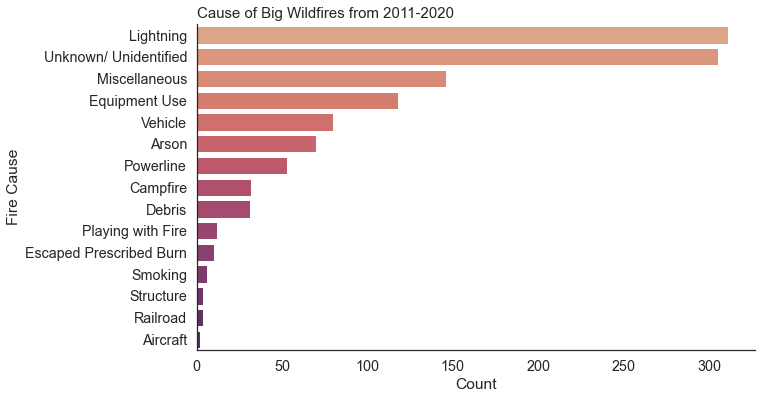

In [106]:
plt.rcParams['figure.figsize'] = [10,6]
sns.set(font_scale = 1.3)
sns.set_style("white")
df2 = Fires_df2[Fires_df2['TotalAcres'] >99]
ax = sns.countplot(y=df2['FireCause'],data=df2, palette="flare", 
                   order=df2['FireCause'].value_counts().index)

ax.set_title("Cause of Big Wildfires from 2011-2020",fontsize = 15, loc='left')
ax.set_xlabel("Count")
ax.set_ylabel("Fire Cause")
sns.despine()

plt.show()

In [107]:
Fires_df2 = Fires_df2.drop(['ObjectID', 'UnitID'], axis = 1)

In [108]:
Fires_df2.rename(columns={"Name_left":"Name"}, inplace=True)
Fires_df2['UniqueId'] = "0B"

In [109]:
Fires_df4.rename(columns={"CaDate":"FireDate", "CaYear":"FireYear", 
                          "CaMonth":"FireMonth", "CaDay":"FireDay", "AcresBurned":"TotalAcres"}, inplace=True)

In [110]:
Fires_df4[Fires_df4.duplicated(['geometry'], keep=False)]

,geometry,FireDate,FireYear,FireMonth,FireDay,TotalAcres,Name,UniqueId


In [111]:
Fires_df = Fires_df2.append(Fires_df4)

In [112]:
Fires_df = Fires_df[~(Fires_df['TotalAcres'] == 0)]

In [113]:
Fires_df = Fires_df.sort_index()

In [114]:
Fires_df['FireYear'].describe()

count    3995.000000
mean     2015.954693
std         2.810346
min      2011.000000
25%      2013.500000
50%      2017.000000
75%      2018.000000
max      2020.000000
Name: FireYear, dtype: float64

In [115]:
Fires_df = Fires_df

In [116]:
Fires_df[['TotalAcres']].describe()

,TotalAcres
count,3.988000e+03
mean,2.983158e+03
std,2.536381e+04
min,1.356887e-03
25%,1.060945e+01
50%,3.700000e+01
75%,2.032367e+02
max,1.032699e+06


#### Check for duplicates by Name

In [117]:
import string
import re

def text_w_punc(text):
    pattern = r'[^A-Za-z ]'
    if re.search("[^0-9]", text):
        pass
    else:
        regex = re.compile(pattern)
        text = regex.sub(' ', text)
    return text

def no_whitespace(string):
    string = string.replace('fire','')
    return string.strip()

def string_lower(df, col):
    # converting all text to lowercase
    df[col] = df[col].str.lower()      
    return df

In [118]:
Fires_df['Name'] = Fires_df['Name'].astype(str)
Fires_df['Name'] = Fires_df['Name'].apply(no_whitespace)
Fires_df['Name'] = Fires_df['Name'].apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
Fires_df['Name'] = Fires_df['Name'].apply(lambda x: text_w_punc(x))
Fires_df = string_lower(Fires_df, "Name")
Fires_df['Name'] = Fires_df['Name'].apply(no_whitespace)

In [119]:
Fires_df.shape

(3995, 9)

In [120]:
f = Fires_df[(Fires_df.duplicated(['Name', 'FireDate'], keep=False)) & 
             (Fires_df['Name']!="")].sort_values(['Name','FireDate', 'TotalAcres'], ascending=False)
print(f.shape)

Fires_df = Fires_df[~((Fires_df.duplicated(['Name', 'FireDate'], keep=False)) & 
                      (Fires_df['Name']!=""))]
print(Fires_df.shape)

(417, 9)
(3578, 9)


In [121]:
multipolygon =f[f['UniqueId']=="0B"]
f = f[~(f['UniqueId']=="0B")]

In [122]:
Fires_df = Fires_df.append(multipolygon)

In [123]:
Fires_df.shape

(3802, 9)

In [124]:
Fires_df[Fires_df.duplicated(['geometry'], keep=False)]

,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,FireDay,Name,UniqueId


#### What fire class is more common?

In [125]:
## Fire Class Binning
# A=greater than 0 but less than or equal to 0.25 acres
# B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres
# E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres)

#binning method for confidence of fire.
bins = [0,.25,9.9,99.9,299,999,4999,1032699.0]
labels = ['A', 'B','C', 'D', 'E', 'F', 'G']
Fires_df['FireSize'] = pd.cut(Fires_df['TotalAcres'], bins=bins, labels=labels)
Fires_df['FireSize']= Fires_df['FireSize'].fillna('A')

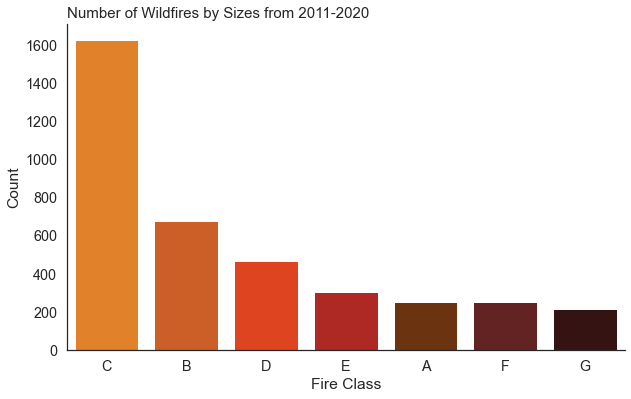

In [126]:
## Fire Class Binning
# A=greater than 0 but less than or equal to 0.25 acres
# B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres
# E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres)

plt.rcParams['figure.figsize'] = [10,6]
colors = ["#FF800D", "#E8540C","#FF3000", "#C5140C", "#7A3000", "#6E1818", "#3B0D0D"]
sns.set_palette(sns.color_palette(colors))
sns.set(font_scale = 1.3)
sns.set_style("white")


ax = sns.countplot(x=Fires_df['FireSize'],data=Fires_df, palette=sns.color_palette(colors), 
                   order=Fires_df['FireSize'].value_counts().index)

ax.set_title("Number of Wildfires by Sizes from 2011-2020",fontsize = 15, loc='left')
ax.set_xlabel("Fire Class")
ax.set_ylabel("Count")
sns.despine()

plt.show()

In [127]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

def plot_cause(df, title):
    
    
    plt.rcParams['figure.figsize'] = [10,6]
    sns.set(font_scale = 1.3)
    sns.set_style("white")
    
    ax = sns.countplot(x=df['FireCause'],data=df, palette="flare",
                       order=df['FireCause'].value_counts().iloc[:5].index)
    ax.set_title(title,fontsize = 15, loc='left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #ax.tick_params(axis='x', labelrotation=90)
    wrap_labels(ax, 5)
    ax.figure
    ax.set_xlabel("Fire Cause")
    ax.set_ylabel("Count")
    sns.despine()

    plt.show()

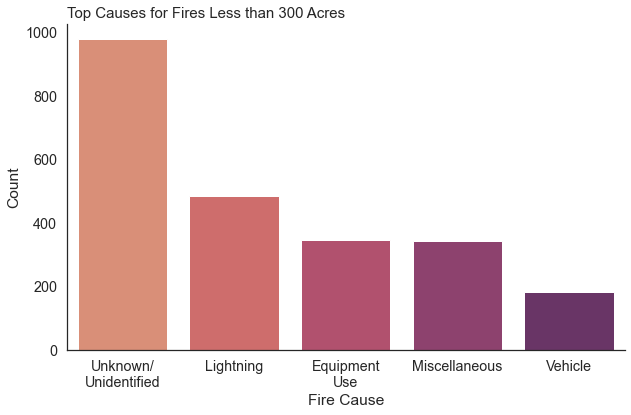

In [128]:
df = Fires_df[(Fires_df['TotalAcres'] <300)]
plot_cause(df, "Top Causes for Fires Less than 300 Acres")

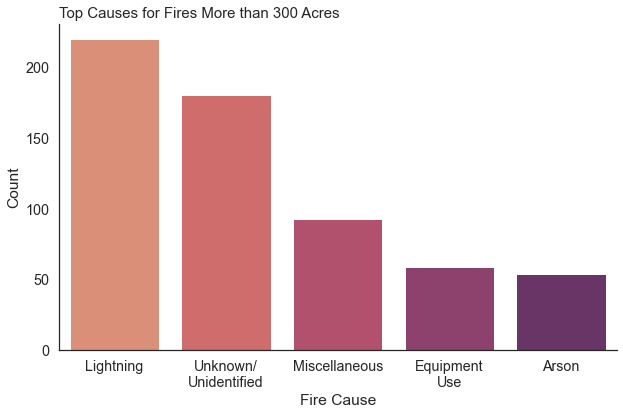

In [129]:
df = Fires_df[(Fires_df['TotalAcres'] >=300)]
plot_cause(df, "Top Causes for Fires More than 300 Acres")

In [130]:
Datatype(Fires_df)

There are 3802 rows and 10 columns
FireCause             object
TotalAcres           float64
geometry            geometry
FireDate      datetime64[ns]
FireYear             float64
FireMonth            float64
FireDay              float64
Name                  object
UniqueId              object
FireSize            category
dtype: object
['TotalAcres' 'FireYear' 'FireMonth' 'FireDay']
['FireCause' 'geometry' 'FireDate' 'Name' 'UniqueId' 'FireSize']


In [131]:
geo_fires_df = Fires_df
geo_fires_df[geo_fires_df.duplicated(['geometry'], keep=False)]

,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,FireDay,Name,UniqueId,FireSize


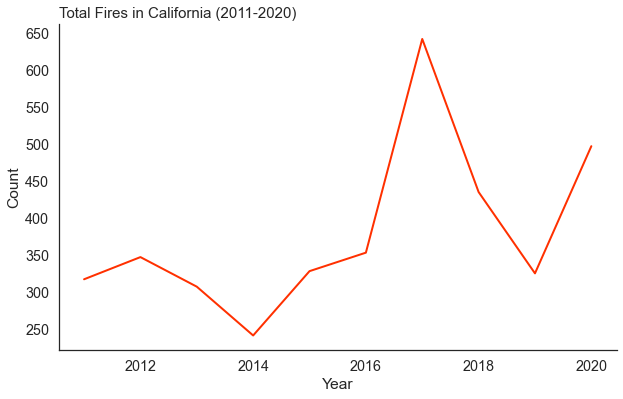

In [133]:
#ca_fires_df = ca_fires_df[ca_fires_df["ReportedAcres"] >= .25]

fire_count = pd.DataFrame(geo_fires_df['FireYear'].value_counts(sort=False))

plt.rcParams['figure.figsize'] = [10,6]
ax = sns.lineplot(data=fire_count, x=fire_count.index, y="FireYear", color="#FF3000", linewidth = 2)


ax.set_title("Total Fires in California (2011-2020)",fontsize = 15,loc='left')
ax.set_xlabel("Year")
ax.set_ylabel("Count")
sns.despine()
plt.show()


#### Which Month had the highest fire counts over time?

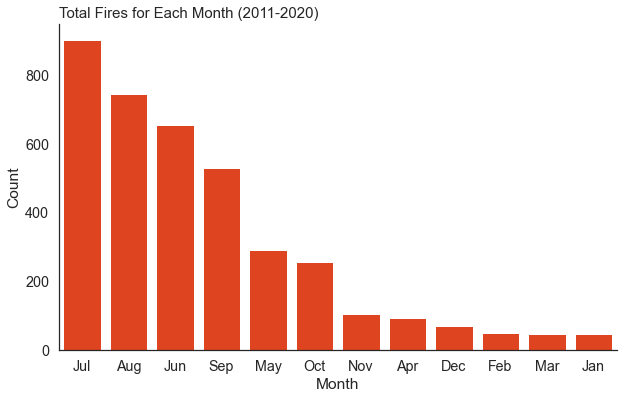

In [134]:
sns.set(font_scale = 1.3)
sns.set_style("white")
df1 = geo_fires_df.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                          5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                          9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
ax = sns.countplot(df1['FireMonth'],data=df1, color="#FF3000", 
                   order=df1['FireMonth'].value_counts().index)

ax.set_title("Total Fires for Each Month (2011-2020)",fontsize = 15, loc='left')
ax.set_xlabel("Month")
ax.set_ylabel("Count")
sns.despine()

plt.show()

In [135]:
plot_gf1 = geo_fires_df.to_crs({'init': "EPSG:4326"})

<AxesSubplot:>

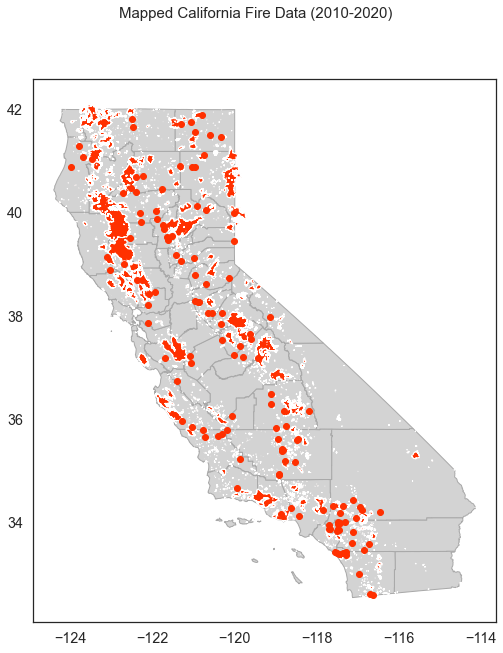

In [136]:
fig, ax = plt.subplots(figsize = (10,10))
fig.suptitle('Mapped California Fire Data (2010-2020)', fontsize=15)
plt.xticks([-124, -122, -120, -118, -116, -114])

USA[USA.STATEFP == '06'].plot(ax = ax, edgecolor="darkgrey", facecolor='lightgrey')
plot_gf1.plot(ax=ax, color="#FF3000")

In [137]:
geo_fires_df.crs

<Derived Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [138]:
def add(date, num):
    end_date = date + dt.timedelta(days=num)
    return end_date

def substract(date, num):
    end_date = date - dt.timedelta(days=num)
    return end_date

In [139]:
Dates = geo_fires_df[['FireDate']]
Dates = Dates.drop_duplicates()

In [140]:
Dates = Dates['FireDate'].tolist()

In [141]:
years = list(range(2010, 2021))
months = list(range(1, 13))
days = list(range(1, 32))

In [142]:
fires_copy = geo_fires_df

### 1b.Data Preliminary Analysis: NASA Active Fire Dataset

In [143]:
Datatype(nasa_df)

There are 1248606 rows and 15 columns
latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence      int64
version        object
bright_t31    float64
frp           float64
daynight       object
type          float64
dtype: object
['latitude' 'longitude' 'brightness' 'scan' 'track' 'acq_time'
 'confidence' 'bright_t31' 'frp' 'type']
['acq_date' 'satellite' 'instrument' 'version' 'daynight']


In [144]:
# Adding new month and day variables
nasa_df['acq_date'] = pd.to_datetime(nasa_df['acq_date'])
nasa_df.rename(columns={"acq_date":"ActiveDate"}, inplace=True)

nasa_df['ActiveYear'] = nasa_df['ActiveDate'].dt.year
nasa_df['ActiveMonth'] = nasa_df['ActiveDate'].dt.month
nasa_df['ActiveDay'] = nasa_df['ActiveDate'].dt.day

In [145]:
#binning method for confidence of fire.
bins = [0, 30,80,100]
labels = ['low', 'nominal','high']
nasa_df['ConfidenceBinned'] = pd.cut(nasa_df['confidence'], bins=bins, labels=labels)
nasa_df['ConfidenceBinned']= nasa_df['ConfidenceBinned'].fillna('low')

In [146]:
# dropping version and instrument variable because it just tells us what version of the instrument is used.
nasa_df = nasa_df.drop(['instrument', 'version', 'acq_time'], axis = 1)
nasa_df = nasa_df.rename(columns={'brightness': 'Brightness', 'scan': 'Scan', 
                                  'track': 'Track', 'longitude': 'NasaLongitude', 
                                  'satellite': 'Satellite', 'confidence':'Confidence', 
                                  'bright_t31':'BrightT31', 'frp': 'Frp', 'daynight': 'DayNight', 
                                  'type': 'HotSpotType','latitude': 'NasaLatitude'})

nasa_df.shape

(1248606, 16)

In [147]:
nasa_df.dropna(inplace=True)

In [148]:
ca_nasa_df = nasa_df[(nasa_df['NasaLatitude']<= 42) & (nasa_df['NasaLatitude'] >= 32)]
ca_nasa_df = ca_nasa_df[(ca_nasa_df['NasaLongitude']<= -114) & (ca_nasa_df['NasaLongitude'] >= -126)]

In [149]:
x = ca_nasa_df[ca_nasa_df['NasaLatitude']<= 42]
y = ca_nasa_df[(ca_nasa_df['NasaLatitude'] >= 42) & (ca_nasa_df['NasaLatitude'] <= 47)]
y = y[y['NasaLongitude'] <=-117.1]

In [150]:
ca_nasa_df = ca_nasa_df[ca_nasa_df['ActiveYear'] >=2011]

In [151]:
ca_nasa_df.shape

(114599, 16)

In [152]:
percentMissing(ca_nasa_df)

NasaLatitude - 0%
NasaLongitude - 0%
Brightness - 0%
Scan - 0%
Track - 0%
ActiveDate - 0%
Satellite - 0%
Confidence - 0%
BrightT31 - 0%
Frp - 0%
DayNight - 0%
HotSpotType - 0%
ActiveYear - 0%
ActiveMonth - 0%
ActiveDay - 0%
ConfidenceBinned - 0%


In [153]:
# check for duplicates in coordinates
duplicate = ca_nasa_df[ca_nasa_df.duplicated(['NasaLatitude', 'NasaLongitude', 'ActiveDate'], keep = False)]
duplicate

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Satellite,Confidence,BrightT31,Frp,DayNight,HotSpotType,ActiveYear,ActiveMonth,ActiveDay,ConfidenceBinned
587108,36.8276,-118.8827,309.6,2.6,1.5,2015-08-20,Terra,78,293.2,35.1,N,0.0,2015,8,20,nominal
589099,36.8276,-118.8827,406.3,1.7,1.3,2015-08-20,Aqua,100,314.4,617.1,D,0.0,2015,8,20,high
701970,36.3855,-121.7702,306.1,3.5,1.8,2016-07-30,Terra,41,294.7,36.1,N,0.0,2016,7,30,nominal
702125,36.3855,-121.7702,373.7,1.0,1.0,2016-07-30,Terra,100,313.0,118.5,D,0.0,2016,7,30,high
982192,40.7501,-122.5168,328.5,1.1,1.0,2018-08-06,Terra,100,292.9,28.7,N,0.0,2018,8,6,high
982434,40.7501,-122.5168,321.9,1.0,1.0,2018-08-06,Aqua,100,290.9,19.3,N,0.0,2018,8,6,high


#### They are not really duplicates and got detected by two separate Satellite

In [154]:
ca_nasa_df.shape

(114599, 16)

In [155]:
# Histograms
def histogram(xaxes, yaxes, df, x, y, nrows, color):
    plt.rcParams['figure.figsize'] = (x, y)
        
    fig, axes = plt.subplots(nrows = nrows, ncols = 2)
    fig.suptitle('Distribution of Fire Pixel Attributes in West Coast Region (2011-2020)', fontsize=20)

    # draw histograms in for loop
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        # drops NaN values
        ax.hist(df[num_features[idx]].dropna(), bins=40, color= color)
        ax.set_xlabel(xaxes[idx], fontsize=15)
        ax.set_ylabel(yaxes[idx], fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)

    plt.show()

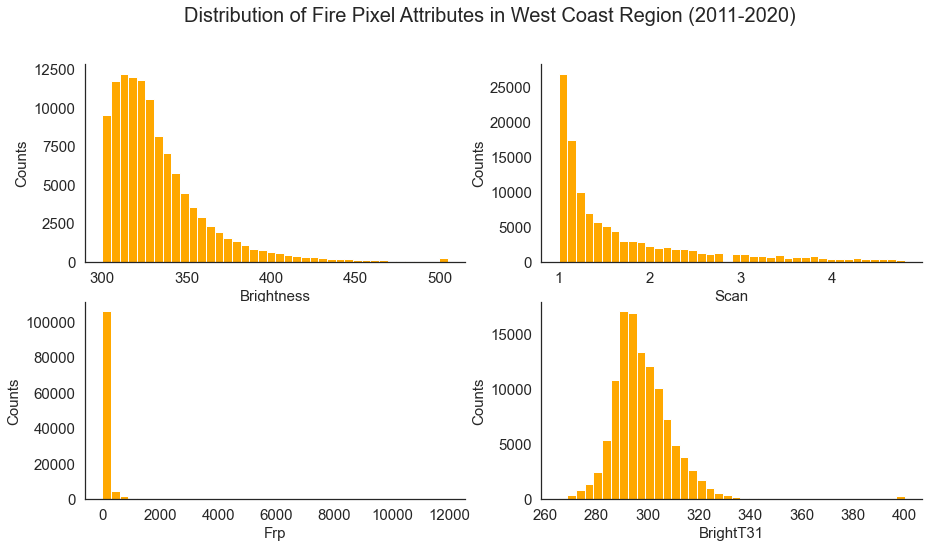

In [156]:
# Specify the features of interest
num_features = ['Brightness', 'Scan', 'Frp', 'BrightT31']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']
histogram(xaxes, yaxes, ca_nasa_df, 15,8, 2, "#ffa800")

In [157]:
geometry = [Point(xy) for xy in zip(ca_nasa_df['NasaLongitude'], ca_nasa_df['NasaLatitude'])]
geometry[:3]

In [158]:
crs = {'init': "EPSG:4326"}
geo_nasa_df = gpd.GeoDataFrame(ca_nasa_df, crs=crs, geometry=geometry)
geo_nasa_df.head(2)

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Satellite,Confidence,BrightT31,Frp,DayNight,HotSpotType,ActiveYear,ActiveMonth,ActiveDay,ConfidenceBinned,geometry
26628,34.6033,-118.3848,305.8,1.2,1.1,2011-01-06,Terra,54,279.1,12.8,D,0.0,2011,1,6,nominal,POINT (-118.38480 34.60330)
26638,39.8467,-121.5210,308.2,1.1,1.0,2011-01-07,Terra,74,277.9,13.5,N,0.0,2011,1,7,nominal,POINT (-121.52100 39.84670)


In [159]:
geo_nasa_df = geo_nasa_df.to_crs({'init': "EPSG:3310"})

In [160]:
y = ca_nasa_df[ca_nasa_df['NasaLongitude'] <=-119.5]
z = ca_nasa_df[(ca_nasa_df['NasaLatitude'] <= 39.5) & (ca_nasa_df['NasaLatitude'] >= 36.5)]
w = z[(z['NasaLongitude'] >=-119.5) & (z['NasaLongitude'] <=-116)]
v = ca_nasa_df[ca_nasa_df['NasaLatitude'] <= 36.5]

plot_df = pd.concat([y,z,w,v])
plot_df = plot_df[~((plot_df['NasaLatitude']>39) & (plot_df['NasaLongitude']>-120))]
plot_df = plot_df[~((plot_df['NasaLatitude']>38) & (plot_df['NasaLongitude']>-118.5))]
plot_df = plot_df[~((plot_df['NasaLatitude']>37) & (plot_df['NasaLongitude']>-117))]
plot_df = plot_df[~((plot_df['NasaLatitude']>36) & (plot_df['NasaLongitude']>-116.5))]


geometry = [Point(xy) for xy in zip(plot_df['NasaLongitude'], plot_df['NasaLatitude'])]
geometry[:3]
plot_df = gpd.GeoDataFrame(plot_df, crs=crs, geometry=geometry)

In [161]:
stcode = ['06']

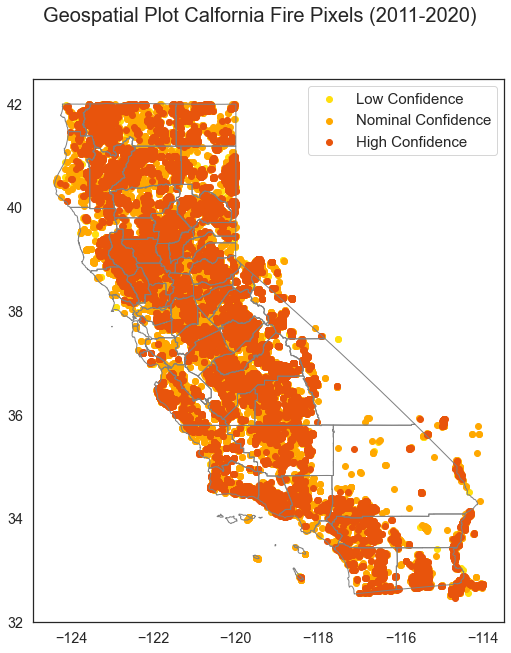

In [162]:
fig, ax = plt.subplots(figsize = (10, 10))
fig.suptitle('Geospatial Plot Calfornia Fire Pixels (2011-2020)', fontsize=20)

plot_df[plot_df['ConfidenceBinned'] == "low"].plot(ax=ax, color="#FFDF0D", label="Low Confidence")
plot_df[plot_df['ConfidenceBinned'] == "nominal"].plot(ax=ax, color="#FFA800", label="Nominal Confidence")
plot_df[plot_df['ConfidenceBinned'] == "high"].plot(ax=ax, color="#E8540C", label="High Confidence")
USA[USA['STATEFP'].isin(stcode)].plot(ax=ax, edgecolor="grey", facecolor="None")
plt.legend(prop={'size':15})

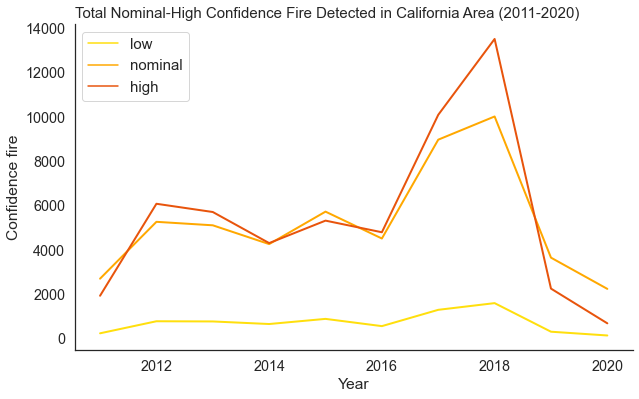

In [163]:
confidence_count = pd.DataFrame(geo_nasa_df[['ConfidenceBinned', 'ActiveYear']].value_counts(sort=False)).reset_index()
confidence_count.columns.values[2] = 'count'
colors = ["#FFDF0D", "#FFA800","#E8540C"]
plt.rcParams['figure.figsize'] = [10,6]
ax = sns.lineplot(data=confidence_count, x="ActiveYear", y='count', hue='ConfidenceBinned', 
                  palette=sns.color_palette(colors), linewidth=2)

ax.set_title("Total Nominal-High Confidence Fire Detected in California Area (2011-2020)",fontsize = 15, loc='left')
ax.set_xlabel("Year")
ax.set_ylabel("Confidence fire")
sns.despine()
plt.legend(prop={'size':15}, loc='upper left')
plt.show()


#### What Hotspot Type has the highest confidence for Fire?

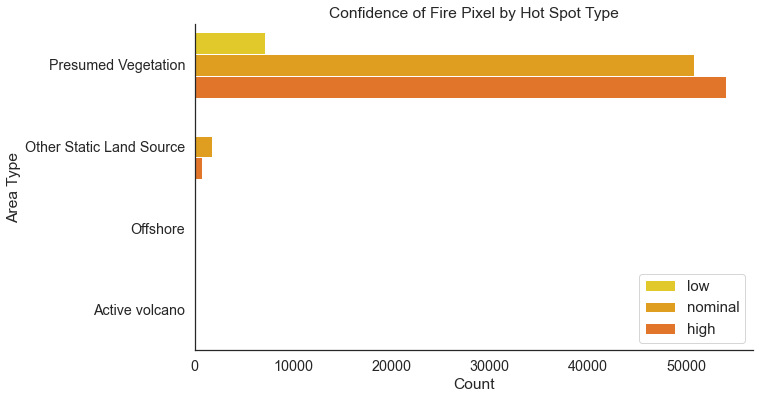

In [164]:
colors = ["#FFDF0D", "#FFA800","#FF710D"]
df1 = geo_nasa_df.replace({'HotSpotType' : {3 : 'Offshore', 2 : 'Other Static Land Source', 
                                         1 : "Active volcano", 0 : "Presumed Vegetation"}})
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = [10,6]
sns.countplot(y=df1['HotSpotType'], data=df1, hue=df1['ConfidenceBinned']).set(title = "Confidence of Fire Pixel by Hot Spot Type", 
                                     xlabel = "Count", ylabel = "Area Type")

sns.despine()
plt.legend(prop={'size':15}, loc='lower right')
plt.show()

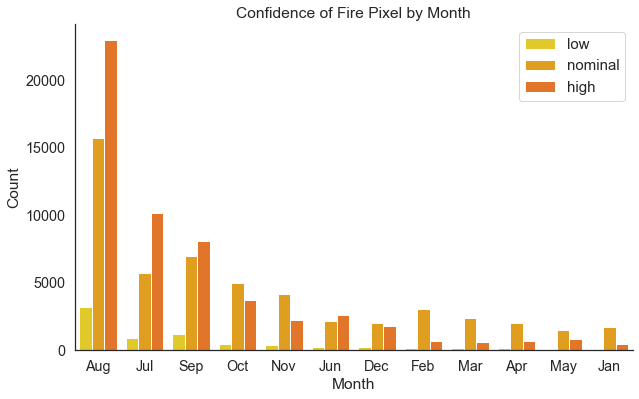

In [165]:
colors = ["#FFDF0D", "#FFA800","#FF710D"]
df1 = geo_nasa_df.replace({'ActiveMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                         5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                         9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = [10,6]
sns.countplot(x=df1['ActiveMonth'], data=df1, hue=df1['ConfidenceBinned'], 
              order=df1['ActiveMonth'].value_counts().index).set(title =  "Confidence of Fire Pixel by Month", 
                                     xlabel = "Month", ylabel = "Count")

sns.despine()
plt.legend(prop={'size':15}, loc='upper right')
plt.show()

### 1c. Data Preliminary Analysis: Drought Data (2010-2020)

In [166]:
drought_soil.head(4)
drought_soil = drought_soil.drop(['Unnamed: 0', 'score'], axis = 1)

In [167]:
drought_soil['DroughtYear'].describe()

count    277628.000000
mean       2015.500411
std           2.872668
min        2011.000000
25%        2013.000000
50%        2016.000000
75%        2018.000000
max        2020.000000
Name: DroughtYear, dtype: float64

In [211]:
y = drought_soil[drought_soil['lon'] <=-119.5]
z = drought_soil[(drought_soil['lat'] <= 39.5) & (drought_soil['lat'] >= 36.5)]
w = z[(z['lon'] >=-119.5) & (z['lon'] <=-116)]
v = drought_soil[drought_soil['lat'] <= 36.5]

plot_df0 = pd.concat([y,z,w,v])
plot_df0 = plot_df0[~((plot_df0['lat']>39) & (plot_df0['lon']>-120))]
plot_df0 = plot_df0[~((plot_df0['lat']>37.6) & (plot_df0['lon']>-118.5))]

geometry = [Point(xy) for xy in zip(plot_df0['lon'], plot_df0['lat'])]
geometry[:3]
geo_soil_df = gpd.GeoDataFrame(plot_df0, crs=crs, geometry=geometry)

In [212]:
soil_df = geo_soil_df[['fips','lat','lon','elevation', 'slope1','slope2','slope3',
                       'slope4','slope6','slope8','aspectN','aspectE', 'aspectS', 
                       'aspectW','WAT_LAND','NVG_LAND','URB_LAND','GRS_LAND', 'FOR_LAND', 
                       'CULTRF_LAND','CULTIR_LAND','SQ2','SQ3', 'SQ4', 'geometry']]
soil_df.shape

(361647, 25)

In [213]:
soil_df = soil_df[~soil_df.duplicated(['fips'], keep='first')]
soil_df.shape

(61, 25)

In [214]:
soil_df[['lat','lon','elevation', 'slope1','slope2','slope3','slope4','slope6','slope8']].describe()

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope6,slope8
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,37.761497,-120.526784,643.426230,0.041205,0.187852,0.117167,0.118982,0.243261,0.049569
std,2.183253,2.200278,678.960148,0.076777,0.267800,0.112690,0.102348,0.183273,0.090065
min,33.023604,-123.980998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.561977,-122.007205,106.000000,0.000400,0.005300,0.029800,0.044400,0.028400,0.000000
50%,38.021451,-120.773446,444.000000,0.001600,0.023200,0.082700,0.096400,0.275800,0.013000
75%,39.177739,-119.749852,825.000000,0.044500,0.322700,0.175900,0.184900,0.402200,0.056300
max,41.749903,-114.038793,2630.000000,0.343100,0.745400,0.561200,0.483300,0.556000,0.481400


In [215]:
soil_df[['aspectN','aspectE', 'aspectS', 'aspectW']].describe()

,aspectN,aspectE,aspectS,aspectW
count,61.000000,61.000000,61.000000,61.000000
mean,0.151067,0.165772,0.192116,0.230715
std,0.093424,0.096897,0.117666,0.137050
min,0.000000,0.000000,0.000000,0.000000
25%,0.064200,0.089500,0.070300,0.128400
50%,0.163600,0.173000,0.201800,0.238000
75%,0.240400,0.226800,0.289000,0.317900
max,0.348700,0.397800,0.473800,0.560200


In [216]:
soil_df[['WAT_LAND','NVG_LAND','URB_LAND','GRS_LAND', 'FOR_LAND', 'CULTRF_LAND','CULTIR_LAND']].describe()

,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1.033192,7.304989,2.745081,18.985231,47.190747,1.722027,16.100701
std,5.806408,19.514630,13.599561,14.832669,31.989077,2.404207,28.713621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,8.869439,18.155117,0.000000,0.000000
50%,0.000000,0.000000,0.055821,15.587294,49.677391,0.272293,0.438461
75%,0.000000,2.083883,0.429140,29.065670,77.980881,3.188647,15.725230
max,44.035000,78.871132,99.955193,58.796833,90.971321,9.187908,99.956841


In [217]:
soil_df[['SQ2','SQ3', 'SQ4']].describe() #### these are discrete variables

,SQ2,SQ3,SQ4
count,61.000000,61.000000,61.000000
mean,1.360656,1.573770,1.163934
std,1.155174,1.257763,1.113258
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000
max,7.000000,7.000000,7.000000


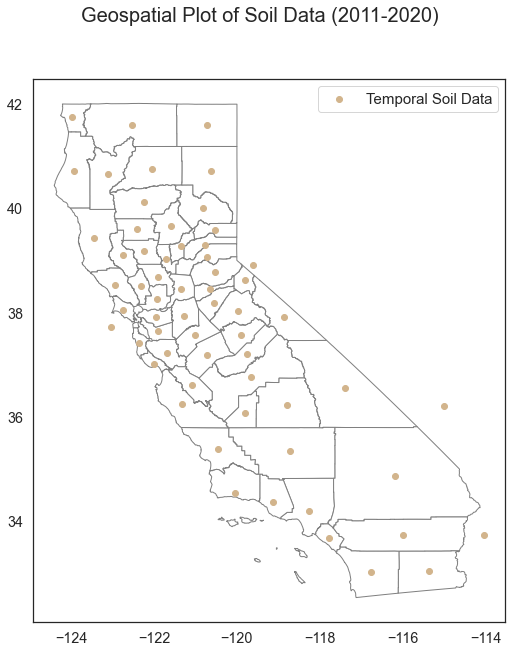

In [218]:
fig, ax = plt.subplots(figsize = (10, 10))
fig.suptitle('Geospatial Plot of Soil Data (2011-2020)', fontsize=20)

USA[USA['STATEFP'].isin(stcode)].plot(ax=ax, edgecolor="grey", facecolor="white")
soil_df.plot(ax=ax, color="tan", label="Temporal Soil Data")
plt.legend(prop={'size':15})

In [219]:
# Histograms
def histogram(xaxes, df, x, y, nrows, color):
    plt.rcParams['figure.figsize'] = (x, y)
        
    fig, axes = plt.subplots(nrows = nrows, ncols = 2)
    fig.suptitle('Distribution of Meteorological Indicators in West Coast Region (2011-2020)', fontsize=30)

    # draw histograms in for loop
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        # drops NaN values
        ax.hist(df[num_features[idx]].dropna(), bins=40, color= color)
        ax.set_xlabel(xaxes[idx], fontsize=15)
        ax.set_ylabel('Counts', fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)

    plt.show()

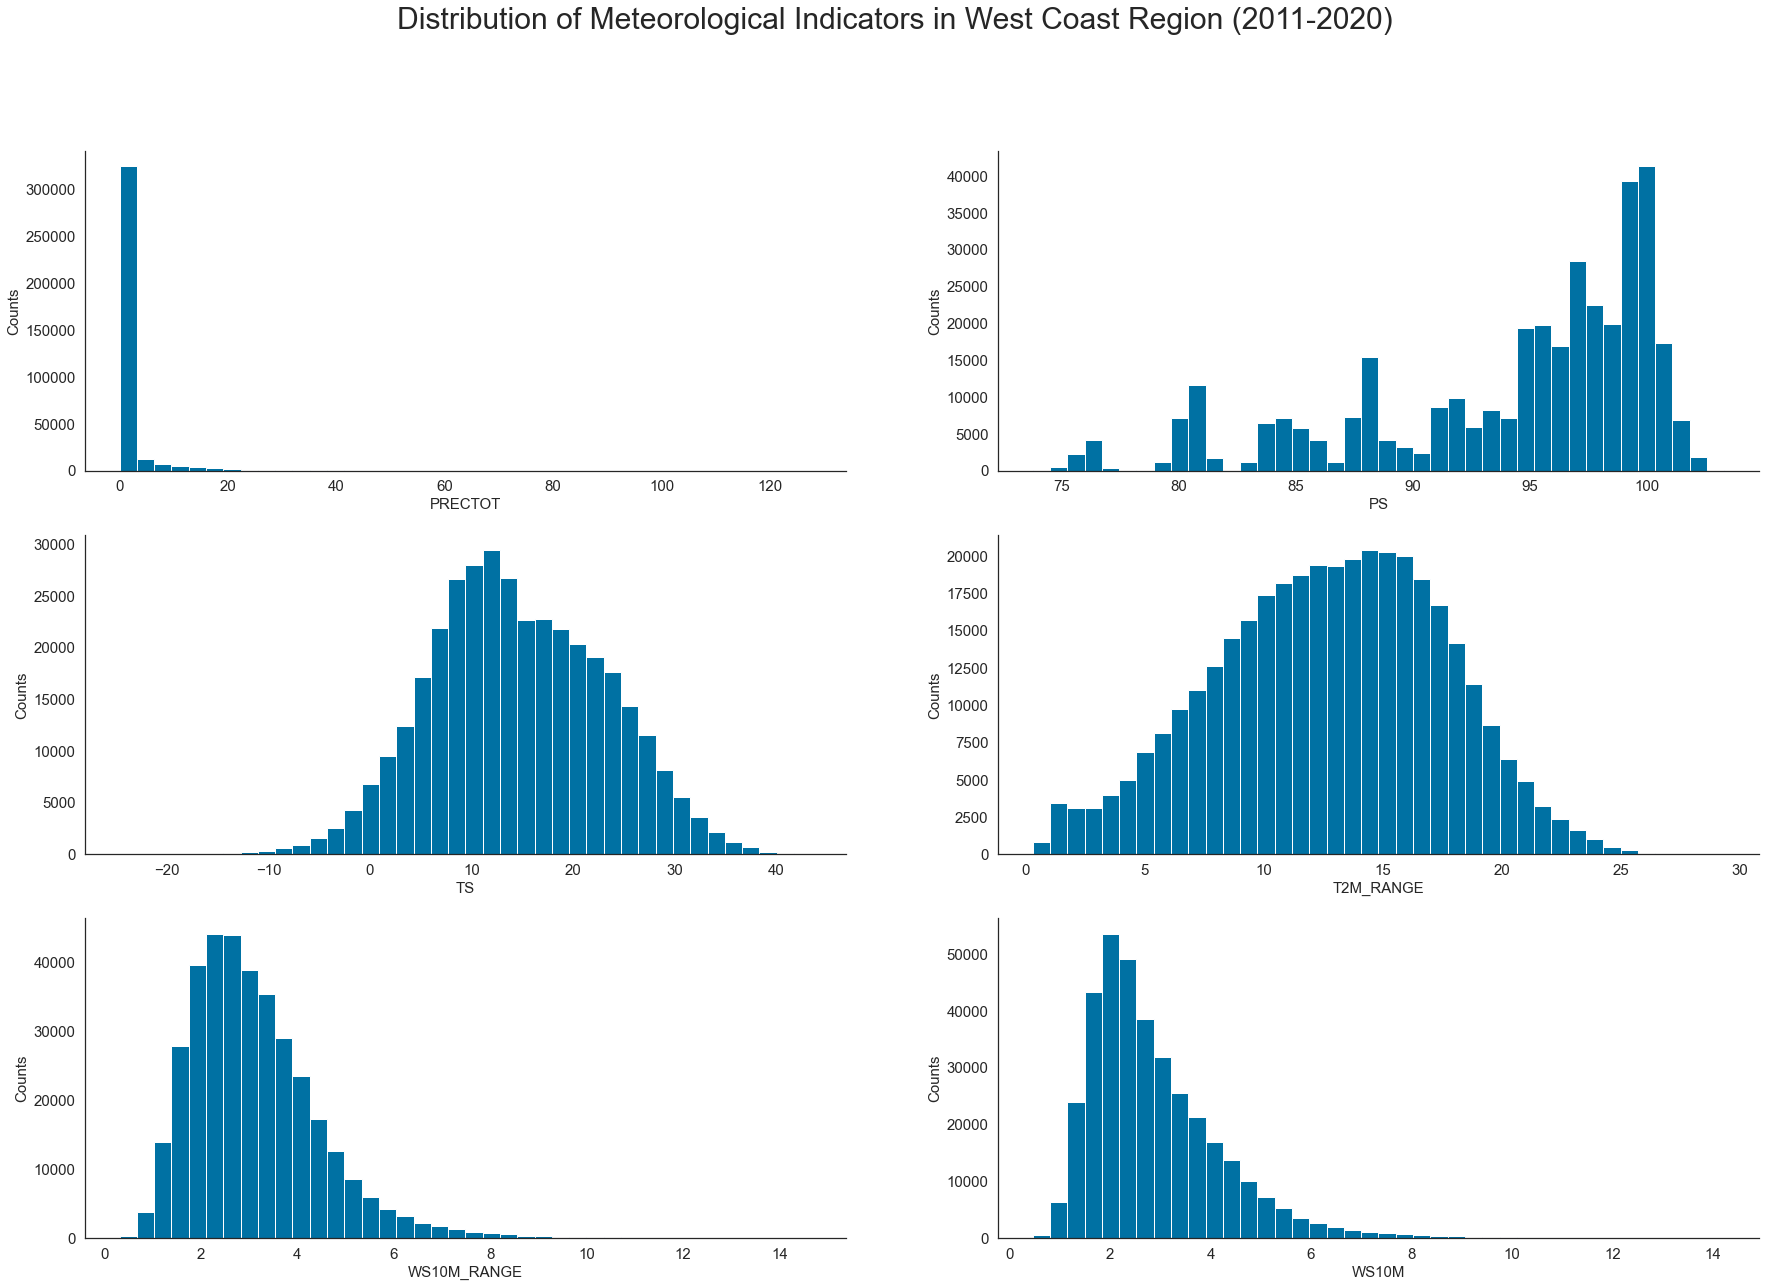

In [220]:
# Specify the features of interest
num_features = ['PRECTOT', 'PS','TS', 'T2M_RANGE', 'WS10M_RANGE', 'WS10M']
xaxes = num_features
histogram(xaxes, geo_soil_df, 30,20, 3, "#0071A3")

In [222]:
grouped = geo_soil_df.groupby(by=['DroughtMonth'] ,as_index=False).agg({'PRECTOT': "mean", 
                                                                        'PS':"mean", 
                                                                        'TS':"mean", 
                                                                        'T2M_RANGE':"mean", 
                                                                        'WS10M_RANGE': "mean", 
                                                                        'WS10M': "mean"})
df = grouped[["PRECTOT",'PS', 'TS', 'T2M_RANGE','WS10M_RANGE', 'WS10M']]
Month_column = grouped[['DroughtMonth']]

In [223]:
sc = StandardScaler()
df_std = sc.fit_transform(df)
df_std = pd.DataFrame(df_std, columns=["PRECTOT",'PS', 'TS', 'T2M_RANGE','WS10M_RANGE', 'WS10M'])
df_std['DroughtMonth'] = Month_column['DroughtMonth']

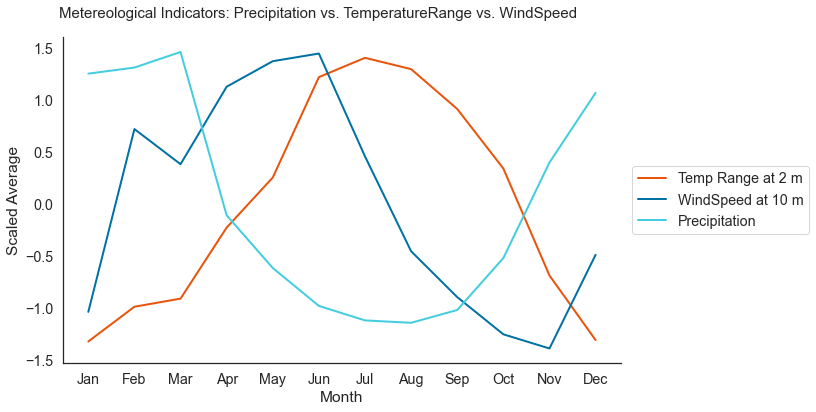

In [224]:
df_std = df_std.replace({'DroughtMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                           5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                           9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Metereological Indicators: Precipitation vs. TemperatureRange vs. WindSpeed', 
             x=0.12, y=.95, horizontalalignment='left', verticalalignment='top', fontsize=15)
plot3 = sns.lineplot(data=df_std, x="DroughtMonth", y='T2M_RANGE', color="#E8540C", linewidth=2, 
                     ax=ax, label="Temp Range at 2 m")
plot4 = sns.lineplot(data=df_std, x="DroughtMonth", y='WS10M', color="#0071A3", linewidth=2, 
                     ax=ax, label="WindSpeed at 10 m")
plot6 = sns.lineplot(data=df_std, x="DroughtMonth", y="PRECTOT", color="#43CDDF", linewidth=2, 
                     ax=ax, label="Precipitation")

ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")

plt.legend(loc="right", bbox_to_anchor=(1.35, 0.5))
sns.despine()
plt.show() 

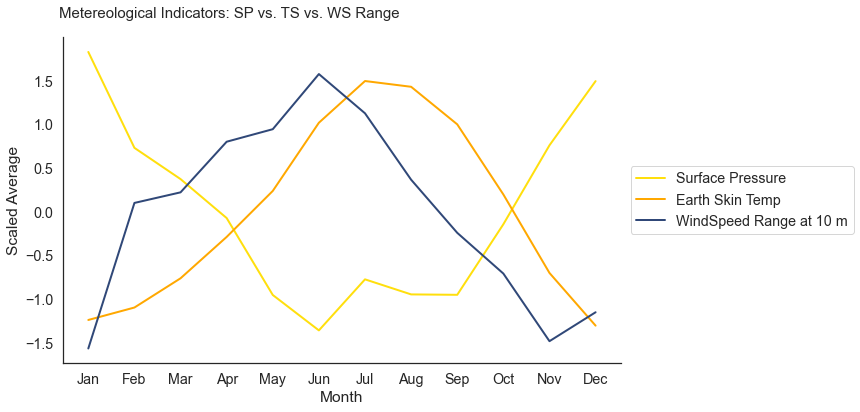

In [225]:
df_std = df_std.replace({'DroughtMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                           5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                           9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Metereological Indicators: SP vs. TS vs. WS Range', 
             x=0.12, y=.95, horizontalalignment='left', verticalalignment='top', fontsize=15)
plot1 = sns.lineplot(data=df_std, x="DroughtMonth", y='PS', color="#FFDF0D", linewidth=2, 
                     ax=ax, label="Surface Pressure")
plot2 = sns.lineplot(data=df_std, x="DroughtMonth", y='TS', color="#FFA800", linewidth=2, 
                     ax=ax, label="Earth Skin Temp")
plot5 = sns.lineplot(data=df_std, x="DroughtMonth", y='WS10M_RANGE', color="#304878", linewidth=2, 
                     ax=ax, label="WindSpeed Range at 10 m")

ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="right", bbox_to_anchor=(1.43, 0.5))
sns.despine()
plt.show() 

### 1d. Data Preliminary Analysis: Daily Summaries (2010 -2020)

In [229]:
ca_daily_df['DATE'] = pd.to_datetime(ca_daily_df['DATE'])
ca_daily_df['TempYear'] = ca_daily_df['DATE'].dt.year
ca_daily_df['TempMonth'] = ca_daily_df['DATE'].dt.month
ca_daily_df['TempDay'] = ca_daily_df['DATE'].dt.day

In [230]:
ca_daily_df = ca_daily_df.rename(columns={'STATION': 'StationCode', 'NAME': 'StationName', 
                                          'LATITUDE': 'StationLatitude', 'LONGITUDE': 'StationLongitude', 
                                          'ELEVATION': 'Elevation', 'DATE':'TempDate', 'PRCP':'Precip',
                                          'TMAX': 'Max_Temp', 'TMIN': 'Min_Temp'})

In [231]:
ca_daily_df['Avg_Temp'] = (ca_daily_df['Min_Temp'] + ca_daily_df['Max_Temp'])/2
ca_daily_df.shape

(1314180, 13)

In [232]:
percentMissing(ca_daily_df)

StationCode - 0%
StationName - 0%
StationLatitude - 3%
StationLongitude - 3%
Elevation - 3%
TempDate - 0%
Precip - 0%
Max_Temp - 0%
Min_Temp - 0%
TempYear - 0%
TempMonth - 0%
TempDay - 0%
Avg_Temp - 0%


#### Deleting duplicates

In [233]:
ca_daily_df.shape

(1314180, 13)

In [234]:
ca_daily_df = ca_daily_df.sort_values(["Max_Temp", "Min_Temp"], ascending=False)

In [235]:
# check for duplicates in coordinates
ca_daily_df = ca_daily_df[~ca_daily_df.duplicated(['StationLatitude', 'StationLongitude', 'TempDate'], keep = 'first')]
ca_daily_df.shape

(1269731, 13)

In [236]:
grouped1 = ca_daily_df.groupby(by=['TempMonth'] ,as_index=False).agg({'Precip': "mean", 'Avg_Temp': "mean"})
df1 = grouped1[["Precip", "Avg_Temp"]]
Month_column1 = grouped1[['TempMonth']]

In [237]:
sc = StandardScaler()
df_std1 = sc.fit_transform(df1)
df_std1 = pd.DataFrame(df_std1, columns=["Precip", "Avg_Temp"])
df_std1['TempMonth'] = Month_column1['TempMonth']

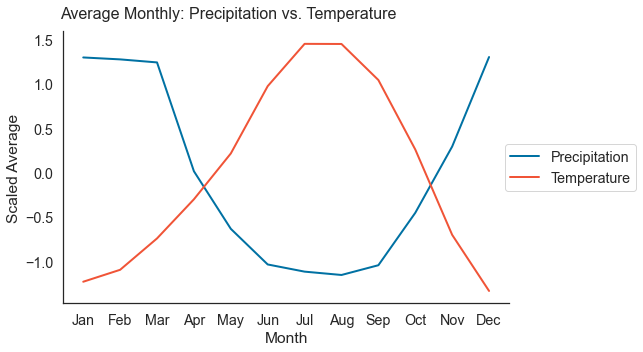

In [238]:
df_std1 = df_std1.replace({'TempMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8,5))
fig.suptitle('Average Monthly: Precipitation vs. Temperature', 
             x=0.12, y=.95, horizontalalignment='left', verticalalignment='top', fontsize=16)
plot1 = sns.lineplot(data=df_std1, x="TempMonth", y='Precip', color="#0071A3", linewidth=2, 
                     ax=ax, label="Precipitation")
plot2 = sns.lineplot(data=df_std1, x="TempMonth", y='Avg_Temp', color="#F05437", linewidth=2, 
                     ax=ax, label="Temperature")

ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))
sns.despine()
plt.show() 

In [239]:
geometry = [Point(xy) for xy in zip(ca_daily_df['StationLongitude'], ca_daily_df['StationLatitude'])]
geometry[:3]
geo_daily_df = gpd.GeoDataFrame(ca_daily_df, crs=crs, geometry=geometry)
geo_daily_df.head(2)

,StationCode,StationName,StationLatitude,StationLongitude,Elevation,TempDate,Precip,Max_Temp,Min_Temp,TempYear,TempMonth,TempDay,Avg_Temp,geometry
99763,USC00042319,"DEATH VALLEY NATIONAL PARK, CA US",36.46263,-116.86720,-59.1,2020-08-16,0.0,130.0,96.0,2020,8,16,113.0,POINT (-116.86720 36.46263)
96964,USW00093115,"IMPERIAL BEACH REAM FIELD NAS, CA US",32.56797,-117.11715,7.2,2010-12-08,0.0,130.0,1.0,2010,12,8,65.5,POINT (-117.11715 32.56797)


In [240]:
geo_daily_df = geo_daily_df.to_crs({'init': "EPSG:3310"})

In [241]:
geo_daily_df['Precip'].describe()

count    1.269731e+06
mean     6.134752e-02
std      2.677502e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.218000e+01
Name: Precip, dtype: float64

#### Plotting Average Monthly Fires with Metereological Indicators

In [242]:
grouped2 = geo_fires_df['FireMonth'].value_counts().to_frame()
grouped2 = grouped2.sort_index()
grouped2.reset_index(level=0, inplace=True)
grouped2['AvgFires'] = grouped2['FireMonth'].apply(lambda x: x/10)
grouped2['FireMonth'] = grouped2['index']
grouped2 = grouped2.iloc[: , 1:]

In [243]:
df2 = grouped2[["AvgFires"]]
Month_column2 = grouped2[['FireMonth']]

In [244]:
sc = StandardScaler()
df_std2 = sc.fit_transform(df2)
df_std2 = pd.DataFrame(df_std2, columns=["AvgFires"])
df_std2['FireMonth'] = Month_column2['FireMonth']

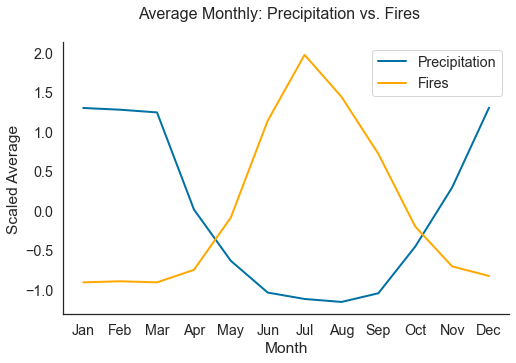

In [245]:
df_std1 = df_std1.replace({'TempMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
df_std2 = df_std2.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8, 5))
fig.suptitle('Average Monthly: Precipitation vs. Fires', fontsize=16)
plot1 = sns.lineplot(data=df_std1, x="TempMonth", y='Precip', color="#0071A3", linewidth=2, 
                     ax=ax, label="Precipitation")
plot4 = sns.lineplot(data=df_std2, x="FireMonth", y='AvgFires', color="#FFA800", linewidth=2, 
                     ax=ax, label="Fires")
ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="upper right")
sns.despine()
plt.show() 

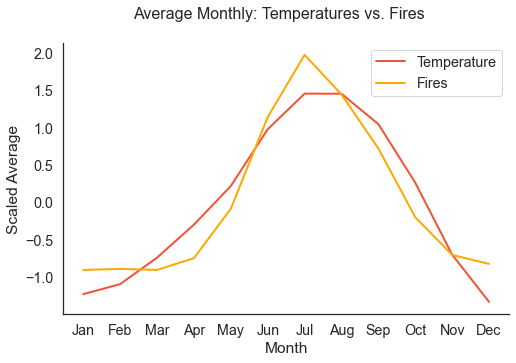

In [246]:
df_std1 = df_std1.replace({'TempMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
df_std2 = df_std2.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8,5))
fig.suptitle('Average Monthly: Temperatures vs. Fires', fontsize=16)
plot2 = sns.lineplot(data=df_std1, x="TempMonth", y='Avg_Temp', color="#F05437", linewidth=2, 
                     ax=ax, label="Temperature")
plot4 = sns.lineplot(data=df_std2, x="FireMonth", y='AvgFires', color="#FFA800", linewidth=2, 
                     ax=ax, label="Fires")
ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="upper right")
sns.despine()
plt.show() 

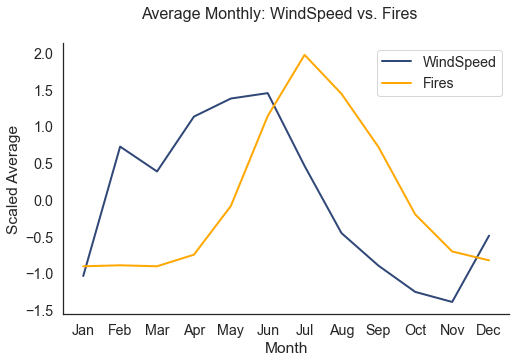

In [247]:
df_std2 = df_std2.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8, 5))
fig.suptitle('Average Monthly: WindSpeed vs. Fires', fontsize=16)
plot3 = sns.lineplot(data=df_std, x="DroughtMonth", y='WS10M', color="#304878", linewidth=2, 
                     ax=ax, label="WindSpeed")
plot4 = sns.lineplot(data=df_std2, x="FireMonth", y='AvgFires', color="#FFA800", linewidth=2, 
                     ax=ax, label="Fires")
ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="upper right")
sns.despine()
plt.show() 

In [248]:
r_df = df_std1[['Precip', 'Avg_Temp']]
r_df['WS'] = df_std['WS10M']
r_df['Avg_Fires'] = df_std2["AvgFires"]

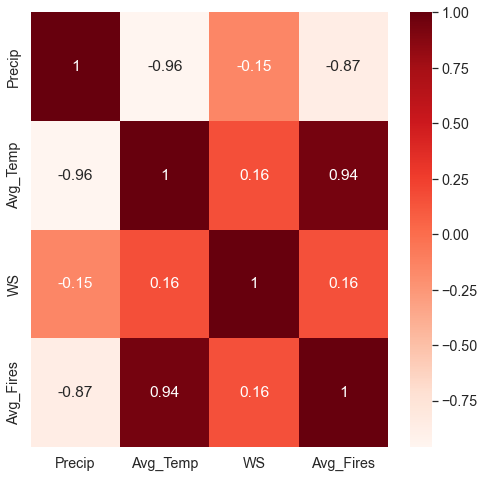

In [249]:
corrmat = r_df.corr()
top = corrmat.index
plt.figure(figsize=(8,8))

                      #plot heat map
g=sns.heatmap(r_df[top].corr(),annot=True,cmap="Reds")

### Dataset 1

In [250]:
print(geo_daily_df.crs)
print(geo_nasa_df.crs)
print(geo_fires_df.crs)
print(geo_soil_df.crs)

+init=epsg:3310 +type=crs
+init=epsg:3310 +type=crs
+init=epsg:3310 +type=crs
+init=epsg:4326 +type=crs


#### First combine all weather and Soil data with nasa dataset

In [251]:
def get_nearestpoint(df1, df1day, df2, df2day, days, dist):
    """
        This Function merges dataframe for selected day by finding nearest points
        for each day and creates mini dfs for each day of month
    """
      
    dfs = [] 
    for day in days:
        df = df1[df1[df1day] == day]
        df3 = df2[df2[df2day] == day]
        m_df = gpd.sjoin_nearest(df, df3, how='left', distance_col=dist)
        m_df[dist] = m_df[dist].apply(lambda x: x/1000)
        d = pd.DataFrame(m_df)
        dfs.append(d)
    
    dfs = pd.concat(dfs)
    return dfs

In [252]:
def merge_data(data1, df1year, df1month, df1day, data2, df2year, df2month,df2day, dist, year, months, days):
    """
        This Function filters dataframe by year and months and calls for day dfs,
        append it and then converts it into pandas df. 
    """
    dfs = []
    for month in months:
        df1 = data1[(data1[df1year] == year) & (data1[df1month] == month)]
        df2 = data2[(data2[df2year] == year) & (data2[df2month] == month)]
        df = get_nearestpoint(df1, df1day, df2, df2day, days, dist)
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    return dfs            

In [253]:
def get_data(df1, df1year, df1month,df1day, df2, df2year, df2month,df2day, dist):
    """
        This calls for all dataframes and combine it and create one dataset for 
        nasa data and daily temperatures 
    """
    years = list(range(2010, 2021))
    months = list(range(1, 13))
    days = list(range(1, 32))
    
    dataframesList = []
    for year in years:
        data = merge_data(df1, df1year, df1month,df1day, df2, df2year, df2month,df2day, dist, year, months, days)
        
        dataframesList.append(data)
    
    df = gpd.GeoDataFrame(pd.concat(dataframesList), crs=crs)
    try:
        df.drop('index_right', axis=1, inplace=True)
    except ValueError:
        # ignore if there are no index columns
        pass
    
    print(df.shape)
    
    return df
    

#### Combine California fire data with nasa DF

In [254]:
pixel_temp = get_data(geo_nasa_df, 'ActiveYear', 'ActiveMonth', 'ActiveDay', 
                      geo_daily_df, 'TempYear', 'TempMonth', 'TempDay', 'Station_dist')

(114599, 31)


In [255]:
pixel_soil = get_data(pixel_temp, 'ActiveYear', 'ActiveMonth', 'ActiveDay', 
                      geo_soil_df, 'DroughtYear', 'DroughtMonth', 'DroughtDay', 'Drought_dist')

(119665, 66)


#### Dropping Duplicates

In [256]:
pixel_soil = pixel_soil[~(pixel_soil.index.duplicated(keep='first'))]

In [257]:
pixel_fire= get_data(pixel_soil, 'ActiveYear', 'ActiveMonth', 'ActiveDay', 
                     geo_fires_df, 'FireYear','FireMonth', 'FireDay', 'fire_dist')

(114599, 76)


In [258]:
merged_df =pixel_fire

In [259]:
# create a set for important variables and target variables.
# Delete repetitive dates, Station name, station codes are not needed. 
# Name of the fire is also irrelevant and acres are also not 
# needed because they are attributes that are logged after the fire events.
merged_df = merged_df.drop(['Satellite', 'StationCode', 'StationName', 'StationLatitude', 'StationLongitude', 
                            'TempDate', 'TempYear', 'TempMonth', 'TempDay', 'fips', 'DroughtDate', 
                            'DroughtYear', 'DroughtMonth', 'DroughtDay', 'FireDate', 'FireMonth', 
                            'FireYear', 'Name', 'UniqueId'], axis = 1)

#### Perform Spatial Analysis

In [260]:
labeled_data = merged_df[merged_df['fire_dist'].notnull()]
unlabeled_data = merged_df[merged_df['fire_dist'].isnull()] # taking pixels that is not mapped to any fire

In [261]:
print(labeled_data.shape)
print(unlabeled_data.shape)

(82493, 57)
(32106, 57)


In [262]:
labeled_data[['fire_dist', 'Station_dist', 'Drought_dist']].describe()

,fire_dist,Station_dist,Drought_dist
count,82493.000000,82493.000000,82493.000000
mean,299.182305,50.681572,310.481150
std,230.135528,85.893810,158.940170
min,0.000000,0.051470,0.260367
25%,122.804595,14.653380,202.725861
50%,237.723699,23.041096,299.132089
75%,430.907748,36.686614,442.452498
max,1259.457214,518.527597,805.499278


The maximum number of TotalAcres burned is 410202 Acres and roughly 1660 km^2, meaning the maximum distance a potential fire goes in any one direction is approximately around 830 km and min 1 km. This could've been a threshold to filter our data out for fire_dist to fire pixel if we were only trying to detect the fire pixel is true fire or not in any given day of the fire (considering fire can go on for weeks). However, the main purpose of this project is to build a model that can be used for early detection of the wildfire, so the hazard can be prevented from spreading. Not all fire pixels are true fire pixels and some times it is a false alarm. So we will filter for pixels that are within than 1 km from the true fire event, 1 km is used as a threshold because MODIS location coordinates are center of 1km fire pixel but not necessarily the actual location of the fire as one or more fires can be detected within the 1km pixel. Randomly sampled data from unlabeled data will be used as false alarms because no fire event was mapped to those dates.

In [263]:
class1 = labeled_data[labeled_data['fire_dist'] <=1]

In [264]:
class1[['fire_dist', 'Station_dist']].describe()

,fire_dist,Station_dist
count,2087.000000,2087.000000
mean,0.218470,20.609494
std,0.285376,12.244417
min,0.000000,0.177639
25%,0.000000,11.653871
50%,0.030367,19.253845
75%,0.410110,27.747893
max,0.999613,71.508454


Station distance is sort of irrelevant as it is maximum 71 km away from the fire pixel, which is usually within county limit, and drastic weather changes are highly unlikely for such close approximation. 

In [265]:
# class2 = unlabeled_data.sample(frac=.08)
unlabeled_fires = labeled_data[labeled_data['fire_dist'] >1]

In [957]:
#class2 = class1.append(class2)

In [266]:
print(class1.shape)
print(unlabeled_fires.shape)
print(unlabeled_data.shape)

(2087, 57)
(80406, 57)
(32106, 57)


#### Check for duplicates after merging

In [267]:
class1[class1.index.duplicated(keep=False)]

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Confidence,BrightT31,Frp,DayNight,...,CULTIR_LAND,SQ2,SQ3,SQ4,Drought_dist,FireCause,TotalAcres,FireDay,FireSize,fire_dist


In [268]:
unlabeled_fires[unlabeled_fires.index.duplicated(keep=False)]

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Confidence,BrightT31,Frp,DayNight,...,CULTIR_LAND,SQ2,SQ3,SQ4,Drought_dist,FireCause,TotalAcres,FireDay,FireSize,fire_dist


In [269]:
unlabeled_data[unlabeled_data.index.duplicated(keep=False)]

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Confidence,BrightT31,Frp,DayNight,...,CULTIR_LAND,SQ2,SQ3,SQ4,Drought_dist,FireCause,TotalAcres,FireDay,FireSize,fire_dist


In [270]:
class1["Target"] = 1
unlabeled_fires["Target"] = 0
unlabeled_data["Target"] = 0
class2 = unlabeled_fires.append(unlabeled_data)

In [273]:
fire_data = class1.append(class2)

In [274]:
fire_data.shape

(114599, 58)

In [275]:
fire_data = fire_data.replace({'DayNight': {'D':1, 'N':0}, 'ConfidenceBinned': {'low':0, 'nominal': 1, 'high':2}})

In [276]:
features = fire_data.drop(['ActiveYear', 'ActiveMonth', 'ActiveDay','Station_dist', 
                           'lat','lon','Drought_dist', 'FireDay', 'fire_dist', 'Target', 
                           'ActiveDate', 'Confidence', 'geometry', 'FireSize', 'TotalAcres'], axis = 1)
features.shape

(114599, 43)

In [277]:
fire_data.to_csv('Data/clean_dataset_preliminary.csv')  

### Final Analysis: Secondary and Optional Approach for Modeling

For this analysis, we will be going back to data preparation part and change the data little bit. For the first approach we took out all the noise data and trained the model with fire pixels that were mapped to the true fire events within the 1 km of the fire event on the day of fire alarm and with the unlabeled fire pixels that were not mapped with the fire events. However, this approach has some biases: 
1. We do not know how much of the unlabeled data (fire pixels that was not mapped to the exact date of fire event) are true fire pixels after the start of fire.
2. All the fire pixels that were about more than 1 km away could also be true fire events on a different day for different fire event, because fire can go on for weeks. For example, for class C fire which is less than 100 acres (0.400639 km^2) can go minimum 0.400639 km and maximum 1 km distance for fire, any fire pixels in that range of distance and duration range between the day of actual fire and the fire containment date can be considered true fire event, anything outside of that distance threshold can be a false alarm, however anything outside of duration but within the 1 km distance means it is an ongoing fire.
    Note: The containment date signifies that control line has been completed around the fire, and any associated spot fires, which can reasonably be expected to stop the fire's spread, but the fire can continue going for months.

There are few assumptions I will be making when creating a transformed dataset only for this project purpose.

### Dataset 2

In [278]:
class1.head() ## True Fire pixels on the day of fire and with distance withing 1 km 

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Confidence,BrightT31,Frp,DayNight,...,SQ2,SQ3,SQ4,Drought_dist,FireCause,TotalAcres,FireDay,FireSize,fire_dist,Target
39687,36.8878,-118.2121,315.9,1.3,1.1,2011-03-02,74,280.6,22.2,D,...,1,1,1,201.810651,Escaped Prescribed Burn,908.44952,2.0,E,0.000000,1
39705,36.8816,-118.2201,305.3,1.5,1.2,2011-03-02,50,291.6,6.2,D,...,1,1,1,201.693111,Escaped Prescribed Burn,908.44952,2.0,E,0.867453,1
77188,37.3252,-118.5696,330.4,3.8,1.8,2011-05-25,0,284.5,184.2,D,...,1,1,1,147.687835,Campfire,206.36874,25.0,D,0.191879,1
77769,35.6501,-118.3755,341.0,2.8,1.6,2011-05-27,88,296.9,165.5,D,...,1,1,1,300.238780,Miscellaneous,1121.37290,27.0,F,0.000000,1
77770,35.6372,-118.3795,320.3,2.8,1.6,2011-05-27,40,302.3,48.4,D,...,1,1,1,301.329821,Miscellaneous,1121.37290,27.0,F,0.000000,1


In [279]:
def get_firepoints(data1, df1year, df1month, df1day, data2, df2year, df2month,df2day, dist, year):
    """
        This Function filters dataframe by year and months and calls for day dfs,
        append it and then converts it into pandas df. 
    """
    months = list(range(1, 13))
    dfs = []
    for month in months:
        df1 = data1[(data1[df1year] == year) & (data1[df1month] == month)]
        df2 = data2[(data2[df2year] == year) & (data2[df2month] == month)]

        df = gpd.sjoin_nearest(df1, df2, how='left', distance_col=dist)
        df[dist] = df[dist].apply(lambda x: x/1000)
        d = pd.DataFrame(df)
        dfs.append(d)
            
    dfs = pd.concat(dfs)
    return dfs  

In [280]:
def get_fire_data(df1, df1year, df1month, df1day, df2, df2year, df2month, df2day, dist):
    """
        This calls_ for all dataframes and combine it and create one dataset for 
        fire data, so we can use the combined information to find the estimated dates
    """
    years = list(range(2011, 2021))
    dataframesList = []
    for year in years:
        data = get_firepoints(df1, df1year, df1month, df1day, df2, df2year, df2month, df2day, dist, year)
        dataframesList.append(data)
    
    df = gpd.GeoDataFrame(pd.concat(dataframesList), crs=crs)
    try:
        df.drop('index_right', axis=1, inplace=True)
    except ValueError:
        # ignore if there are no index columns
        pass
    
    print(df.shape)
    
    return df

In [281]:
pixel_soil.head(2)

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Satellite,Confidence,BrightT31,Frp,...,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ2,SQ3,SQ4,Drought_dist
26628,34.6033,-118.3848,305.8,1.2,1.1,2011-01-06,Terra,54,279.1,12.8,...,19.205658,0.005869,1.820019,4.046427,0.0,74.922028,1,1,1,406.007432
26638,39.8467,-121.5210,308.2,1.1,1.0,2011-01-07,Terra,74,277.9,13.5,...,0.000000,0.080900,16.224855,83.694244,0.0,0.000000,2,1,1,242.245072


In [282]:
geo_fires_df = geo_fires_df[geo_fires_df['TotalAcres'].notnull()]

In [283]:
geo_fires_df['TotalAcres_sq_km'] = geo_fires_df['TotalAcres'].apply(lambda x: x*4047/1000000)

In [284]:
print(geo_fires_df.shape)
geo_fires_df.head(2)

(3795, 11)


,FireCause,TotalAcres,geometry,FireDate,FireYear,FireMonth,FireDay,Name,UniqueId,FireSize,TotalAcres_sq_km
0,Powerline,109.60250,"MULTIPOLYGON (((-116842.172 97942.739, -116837...",2020-06-18,2020.0,6.0,18.0,nelson,0B,D,0.443561
1,Equipment Use,685.58502,"MULTIPOLYGON (((-117329.343 90212.620, -117322...",2020-06-01,2020.0,6.0,1.0,amoruso,0B,E,2.774563


In [285]:
pixel_fire2= get_fire_data(pixel_soil, 'ActiveYear', 'ActiveMonth', 'ActiveDay', 
                           geo_fires_df, 'FireYear','FireMonth', 'FireDay', 'fire_dist')

(114599, 77)


In [286]:
merged_df2 = pixel_fire2

In [287]:
# create a set for important variables and target variables.
# Delete repetitive dates, Station name, station codes are not needed. 
# Name of the fire is also irrelevant and acres are also not 
# needed because they are attributes that are logged after the fire events.
merged_df2 = merged_df2.drop(['Satellite', 'StationCode', 'StationName', 'StationLatitude', 'StationLongitude', 
                            'TempDate', 'TempYear', 'TempMonth', 'TempDay', 'fips', 'DroughtDate', 
                            'DroughtYear', 'DroughtMonth', 'DroughtDay','UniqueId', 'FireSize'], axis = 1)

In [288]:
mapped_fire = merged_df2[merged_df2['fire_dist'].notnull()]
unmapped_fire = merged_df2[merged_df2['fire_dist'].isnull()] # taking pixels that is not mapped to any fire

In [289]:
print(mapped_fire.shape)
print(unmapped_fire.shape)

(113912, 61)
(687, 61)


In [290]:
mapped_fire['fire_dist'].describe()

count    113912.000000
mean         79.608633
std         127.814990
min           0.000000
25%           0.000000
50%          29.523428
75%          87.483079
max        1151.519722
Name: fire_dist, dtype: float64

In [291]:
def get_duration(df):
    df['Active_minus_FireDate'] = (df["ActiveDate"] - df["FireDate"]).dt.days
    df['Area_diff'] = (df["TotalAcres_sq_km"] - df["fire_dist"])
    df = df.sort_values('Active_minus_FireDate', ascending=True)
    
    return df

In [292]:
mapped_fire = get_duration(mapped_fire)

In [293]:
# fire distance bigger than total Acres means fire is outside of range and do not belong to the fire. 
# We used 32 km (10 miles) as a threshold for the area. Any fire outside of 5 km radius of the location is too far
all_false = mapped_fire[(mapped_fire['TotalAcres_sq_km'] <=100) & 
                        (mapped_fire['fire_dist'] >100) & (mapped_fire['Area_diff'] <0)].sort_values('fire_dist', ascending=False)


In [294]:
all_fire = mapped_fire[~((mapped_fire['TotalAcres_sq_km'] <=100) & 
                         (mapped_fire['fire_dist'] >100) & 
                         (mapped_fire['Area_diff'] <0))].sort_values('fire_dist', ascending=False)

In [295]:
f = all_fire[(all_fire['TotalAcres_sq_km'] <200) & 
             (all_fire['fire_dist'] >200) & 
             (all_fire['Area_diff'] <0)]

all_false = all_false.append(f)

In [296]:
all_fire = all_fire[~((all_fire['TotalAcres_sq_km'] <200) & 
                      (all_fire['fire_dist'] >200) & 
                      (all_fire['Area_diff'] <0))]

In [297]:
f = all_fire[(all_fire['TotalAcres_sq_km'] <400) & 
             (all_fire['fire_dist'] >400) & 
             (all_fire['Area_diff'] <0)]

all_false = all_false.append(f)

In [298]:
all_fire = all_fire[~((all_fire['TotalAcres_sq_km'] <400) & 
                      (all_fire['fire_dist'] >400) & 
                      (all_fire['Area_diff'] <0))]

In [299]:
f = all_fire[(all_fire['TotalAcres_sq_km'] <5) & 
             (all_fire['fire_dist'] >5.99) & 
             (all_fire['Area_diff'] <0)]

all_false = all_false.append(f)

In [300]:
all_fire = all_fire[~((all_fire['TotalAcres_sq_km'] <5) & 
                      (all_fire['fire_dist'] >5.99) & 
                      (all_fire['Area_diff'] <0))]

In [301]:
f = all_fire[(all_fire['Area_diff'] <0)]
all_false = all_false.append(f)
all_false = all_false.append(unmapped_fire)

In [302]:
all_fire = all_fire[~(all_fire['Area_diff'] <0)]

#### Removing duplicates from all the merging

In [303]:
False_pixels = all_false[~all_false.index.duplicated(keep='first')]
False_pixels = get_duration(False_pixels)
False_pixels.shape

(67863, 63)

In [304]:
True_pixels = all_fire[~all_fire.index.duplicated(keep='first')]
True_pixels = get_duration(True_pixels)
True_pixels.shape

(46736, 63)

#### Filtering for California Pixels only

In [305]:
x = False_pixels[~((False_pixels['NasaLongitude'] >-119.8) & (False_pixels['NasaLatitude'] >39))]
y = x[~((x['NasaLongitude'] >-119) & (x['NasaLatitude'] >38))]
False_pixels = y[~((y['NasaLongitude'] >-118) & (y['NasaLatitude'] >35.9))]
False_pixels.shape

(57935, 63)

In [306]:
geometry1 = [Point(xy) for xy in zip(False_pixels['NasaLongitude'], False_pixels['NasaLatitude'])]
geometry1[:3]
plot_df1 = gpd.GeoDataFrame(False_pixels, crs=crs, geometry=geometry1)

In [307]:
True_pixels = True_pixels[~((True_pixels['NasaLongitude'] >-119.8) & (True_pixels['NasaLatitude'] >39))]
True_pixels.shape

(45186, 63)

In [308]:
geometry2 = [Point(xy) for xy in zip(True_pixels['NasaLongitude'], True_pixels['NasaLatitude'])]
geometry2[:3]
plot_df2 = gpd.GeoDataFrame(True_pixels, crs=crs, geometry=geometry2)

#### Plotting all Labeled and Unlabeled Fires

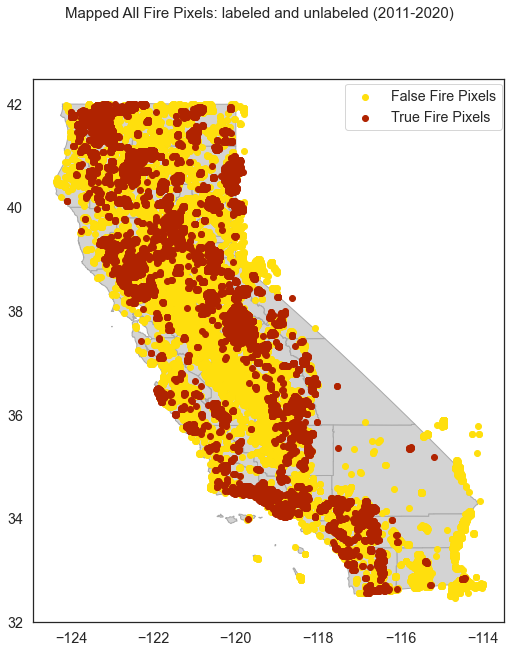

In [309]:
fig, ax = plt.subplots(figsize = (10,10))
fig.suptitle('Mapped All Fire Pixels: labeled and unlabeled (2011-2020)', fontsize=15)
plt.yticks([32, 34, 36, 38, 40, 42])
plt.xticks([-124, -122, -120, -118, -116, -114])

plt0 = USA[USA.STATEFP == '06'].plot(ax = ax, edgecolor="darkgrey", facecolor='lightgrey')
plt1 = plot_df1.plot(ax=ax, color="#FFDF0D", label="False Fire Pixels")
plt2 = plot_df2.plot(ax=ax, color="#B02300", label="True Fire Pixels")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.65,0.8))
plt.show()

In [310]:
plot_gf1 = geo_fires_df.to_crs({'init': "EPSG:4326"})

In [311]:
plot_df2 = plot_df2[(plot_df2['Active_minus_FireDate'] >=-1) & (plot_df2['Active_minus_FireDate'] <=1)]

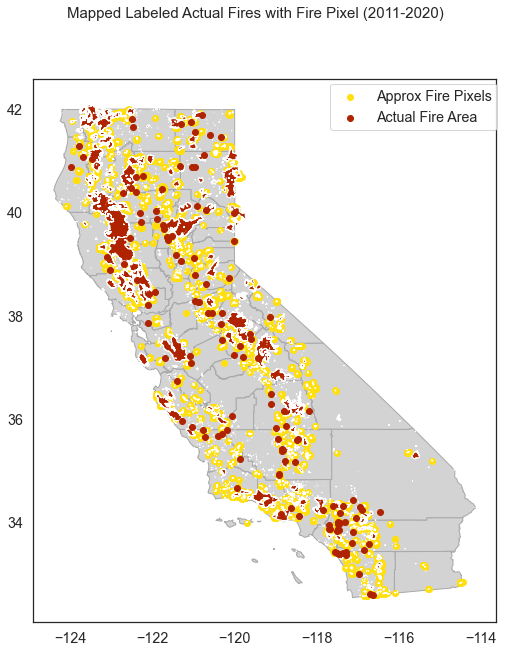

In [312]:
fig, ax = plt.subplots(figsize = (10,10))
fig.suptitle('Mapped Labeled Actual Fires with Fire Pixel (2011-2020)', fontsize=15)
plt.yticks([32, 34, 36, 38, 40, 42])
plt.xticks([-124, -122, -120, -118, -116, -114])

plt0 = USA[USA.STATEFP == '06'].plot(ax = ax, edgecolor="darkgrey", facecolor='lightgrey')
plt1 = plot_df2.plot(ax=ax, color="#FFDF0D", label="Approx Fire Pixels")
plt2 = plot_gf1.plot(ax=ax, color="#B02300", label ="Actual Fire Area")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.63,0.8))

plt.show()

In [313]:
dta0 = False_pixels.drop(['fire_dist','TotalAcres_sq_km', 'Active_minus_FireDate', 'Area_diff'], axis = 1)

dta1 = True_pixels.drop(['fire_dist','TotalAcres_sq_km', 'Active_minus_FireDate', 'Area_diff'], axis = 1)

In [314]:
print(dta0.shape)
print(dta1.shape)

(57935, 59)
(45186, 59)


In [315]:
dta1["Target"] = 1
dta0["Target"] = 0

In [316]:
new_data = dta1.append(dta0)

In [317]:
new_data = new_data.replace({'DayNight': {'D':1, 'N':0}})
new_data = new_data.reset_index(drop=True)

In [318]:
new_data = new_data.sort_values(['ActiveDate'])

new_data['geometry'] = list(zip(new_data['NasaLongitude'], new_data['NasaLatitude']))

In [319]:
new_df = new_data.set_index(['ActiveDate', 'geometry'])

In [320]:
new_df.to_csv('Data/clean_dataset1.csv')  